# Machine Learning Data Challenge 2023

Author: Matei-Gabriel Cosa 
Instructors: prof. Andrea Celli & TA Elisaveta Demyanenko

## Introduction

The goal of this challenge is to predict the price of houses in different Italian cities based on a number of features, such as location, size, etc. We will proceed by importing, describing, cleaning and preprocessing the data in order to feed it to different models and assess their performance. In the end we will use our best model to construct a submission file for the Kaggle competition.

## Importing the data & preliminary analysis

Install useful libraries:

In [ ]:
!pip install -r requirements.txt

In [11]:
import os 

cdir_path = os.getcwd() # working directory

In [12]:
# Import some useful libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/mateicosa/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
# Import training dataset
df = pd.read_csv(cdir_path + '/data/' + 'train.csv')
# preview the data
df.head(10)

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,10461,60000,True,Buono stato / Abitabile,1980.0,41.901300,12.700000,175.00,30.0,2.0,NaN,1.0,NaN,3.0,1.0,1.00000,35.0
1,51304,900000,NaN,Buono stato / Abitabile,NaN,41.907017,12.481311,NaN,NaN,3.0,NaN,1.0,1.0,NaN,3.0,1.00000,131.0
2,33032,33000,NaN,Buono stato / Abitabile,1960.0,41.976500,12.440500,204.20,30.0,4.0,NaN,1.0,NaN,4.0,1.0,1.00000,16.0
3,62281,166000,NaN,Ottimo / Ristrutturato,NaN,45.484800,12.198200,175.00,NaN,1.0,True,1.0,NaN,1.0,2.0,0.99205,100.0
4,45681,410000,True,Buono stato / Abitabile,NaN,45.424480,12.328622,65.91,NaN,3.0,NaN,2.0,1.0,NaN,3.0,1.00000,90.0
5,59924,89000,NaN,Buono stato / Abitabile,NaN,41.874581,12.541382,NaN,NaN,-1.0,NaN,1.0,NaN,NaN,2.0,1.00000,30.0
6,36856,632000,True,Buono stato / Abitabile,NaN,41.864600,12.500900,202.39,NaN,2.0,NaN,3.0,1.0,5.0,4.0,1.00000,NaN
7,47960,147000,True,Buono stato / Abitabile,1960.0,45.501742,12.254337,NaN,150.0,-1.0,NaN,1.0,1.0,NaN,5.0,1.00000,107.0
8,7326,275000,True,Ottimo / Ristrutturato,1950.0,41.896900,12.519100,175.00,60.0,6.0,NaN,1.0,1.0,7.0,3.0,1.00000,75.0
9,44039,459000,True,Ottimo / Ristrutturato,1995.0,41.906400,12.420300,175.00,100.0,0.0,True,3.0,NaN,2.0,5.0,1.00000,130.0


In [1926]:
# print some general info about the dataset
n_obs, n_feat = df.shape
print(f"Dataset has {n_obs} observations and {n_feat} features.")
print(f"Dataset has {sum(df.isnull().sum())} missing values out of {n_obs * n_feat} total observations.") 

Dataset has 46312 observations and 17 features.
Dataset has 139278 missing values out of 787304 total observations.


We observe that the dataset is quite large, which should allow us to have sufficient data to perform cross-validation and train our models on many examples. However, we also notice that the dataset has a high number of missing observations which we must address. 

## Descriptive & exploratory data analysis

We start by looking at our target variable: price. 

In [1927]:
# General info
pd.set_option('float_format', '{:f}'.format)
df['price'].describe()

count      46312.000000
mean      503187.893224
std      1106504.296902
min          154.000000
25%       199000.000000
50%       315000.000000
75%       515000.000000
max     72000000.000000
Name: price, dtype: float64

In [1928]:
print("Skewness of price distribution: %f" % df['price'].skew())
print("Kurtosis of price distribution: %f" % df['price'].kurt())
print("Skewness of log-price distribution: %f" % np.log(df['price']).skew())
print("Kurtosis of log-price distribution: %f" % np.log(df['price']).kurt())

Skewness of price distribution: 24.733627
Kurtosis of price distribution: 1012.453475
Skewness of log-price distribution: 0.529227
Kurtosis of log-price distribution: 2.586761


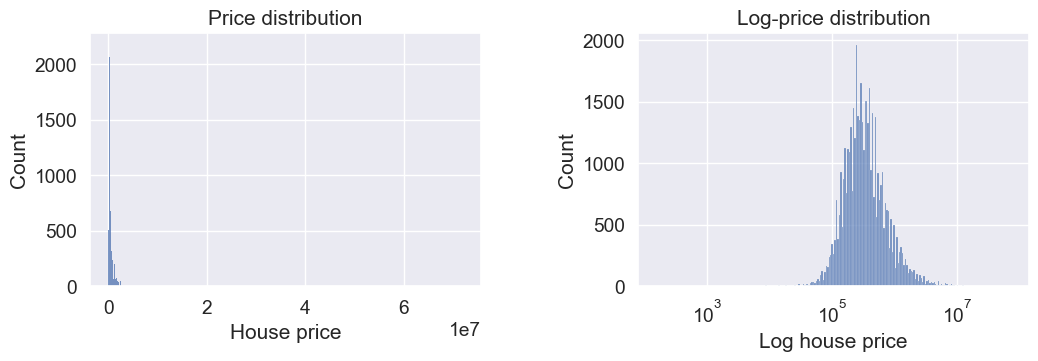

In [1929]:
# plot the histogram of the 'price' as well as log('price')

fig, axis = plt.subplots(1, 2, figsize=(12, 5))
fig.tight_layout(pad=5.0)
ax1, ax2 = axis
sns.histplot(df['price'], ax = ax1) 
ax1.set_title(r'Price distribution')
ax1.set_xlabel(r'House price')
legend = ax1.get_legend()
sns.histplot(df['price'], log_scale = True, ax = ax2) 
ax2.set_title(r'Log-price distribution')
ax2.set_xlabel(r'Log house price')
legend = ax1.get_legend()

The mean of the distribution is around 500000, the minimum is as low as 154, while the maximum reaches 72000000. There is relatively high variability in the data and there appear to be outliers. To test this, we will develop a more formal analysis. \
The distribution of the house prices is clearly right-skewed. If, however, we plot the histogram of the logarithm of the prices we obtain a figure that resembles a bell-shaped curve. These findings are enforced by the values of the skewness and kurtosis computed for the two cases, with the log-price distribution being relatively close to a Gaussian.

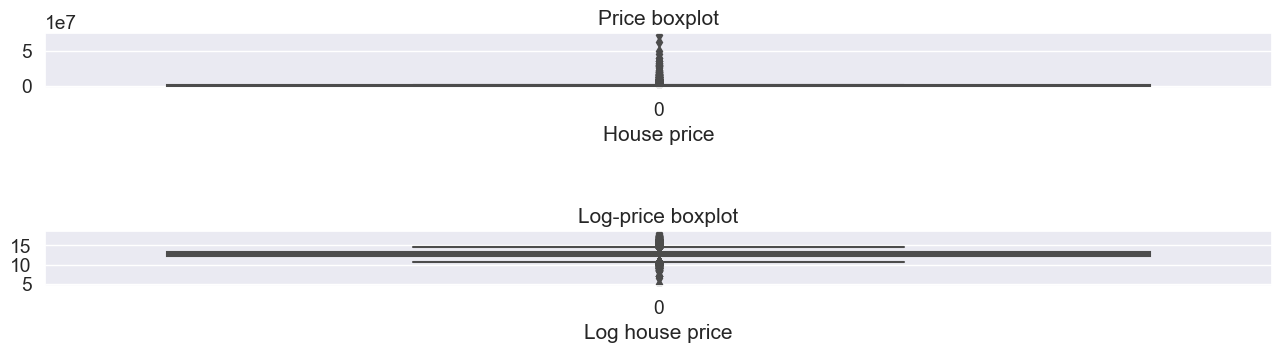

In [1930]:
# create boxplots

fig, axis = plt.subplots(2, 1, figsize=(15, 5))
fig.tight_layout(pad=5.0)
ax1, ax2 = axis
sns.boxplot(df['price'], ax = ax1)
ax1.set_title(r'Price boxplot')
ax1.set_xlabel(r'House price')
legend = ax1.get_legend()
sns.boxplot(np.log(df['price']), ax = ax2)
ax2.set_title(r'Log-price boxplot')
ax2.set_xlabel(r'Log house price')
legend = ax2.get_legend()

In [1931]:
# more 'formal' test for outliers, assuming an outlier is located outside the range [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]

Q1 = np.quantile(df['price'], 0.25)
Q3 = np.quantile(df['price'], 0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"There are {sum(df['price'] < lower_bound)} lower_outliers.")
print(f"There are {sum(df['price'] > upper_bound)} upper_outliers.")

There are 0 lower_outliers.
There are 3890 upper_outliers.


We will have to find a way to deal with this outliers. But first we take a look at the other features in the dataset.

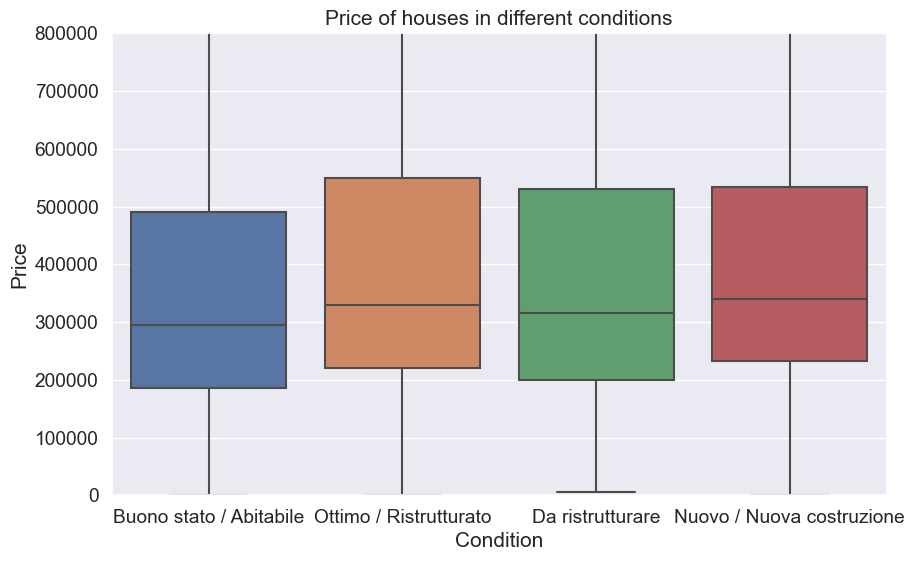

In [1932]:
# boxplot of prices in all the conditions

data = pd.concat([df['price'], df['conditions']], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.boxplot(x = 'conditions', y = 'price', data = data)
fig.axis(ymin = 0, ymax = 800000)
ax.set_title(r'Price of houses in different conditions')
ax.set_xlabel(r'Condition')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

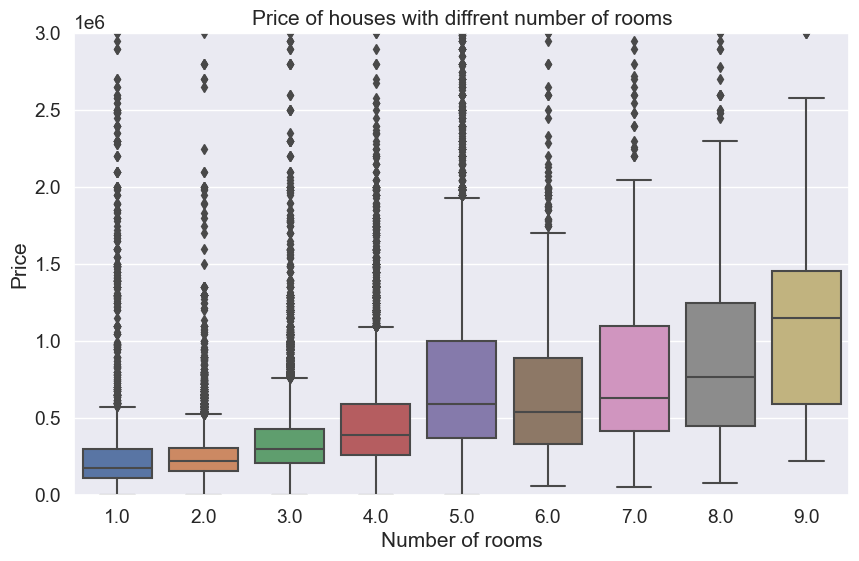

In [1933]:
# boxplot of prices with different number of rooms

data = pd.concat([df['price'], df['n_rooms']], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.boxplot(x = 'n_rooms', y = 'price', data = data)
fig.axis(ymin = 0, ymax = 3000000)
ax.set_title(r'Price of houses with diffrent number of rooms')
ax.set_xlabel(r'Number of rooms')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

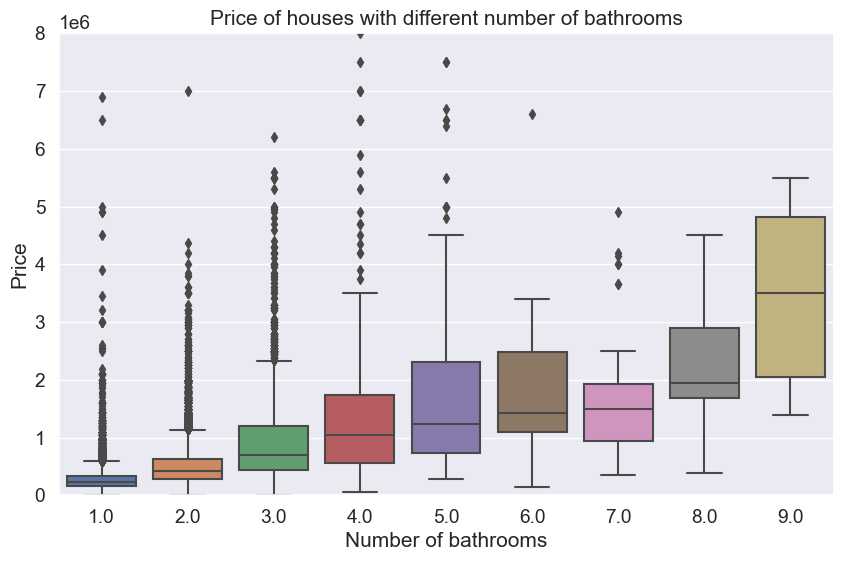

In [1934]:
# boxplot of prices in all the conditions

data = pd.concat([df['price'], df['n_bathrooms']], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.boxplot(x = 'n_bathrooms', y = 'price', data = data)
fig.axis(ymin = 0, ymax = 8000000)
ax.set_title(r'Price of houses with different number of bathrooms')
ax.set_xlabel(r'Number of bathrooms')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

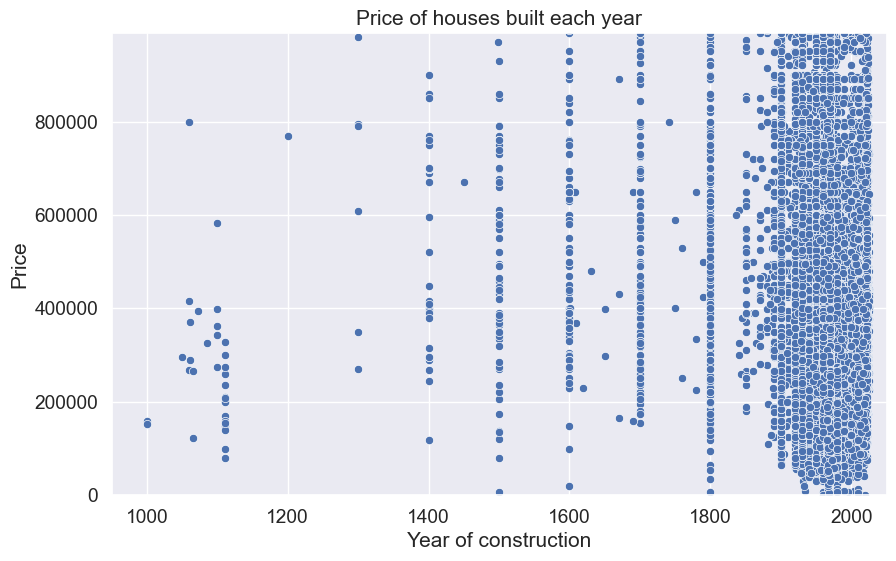

In [1935]:
# scatterplot of prices of houses built each year

data = pd.concat([df['price'], df['construction_year']], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'construction_year', y = 'price', data = data)
fig.axis(xmin = 950, xmax = 2050, ymin = 0, ymax = upper_bound)
ax.set_title(r'Price of houses built each year')
ax.set_xlabel(r'Year of construction')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

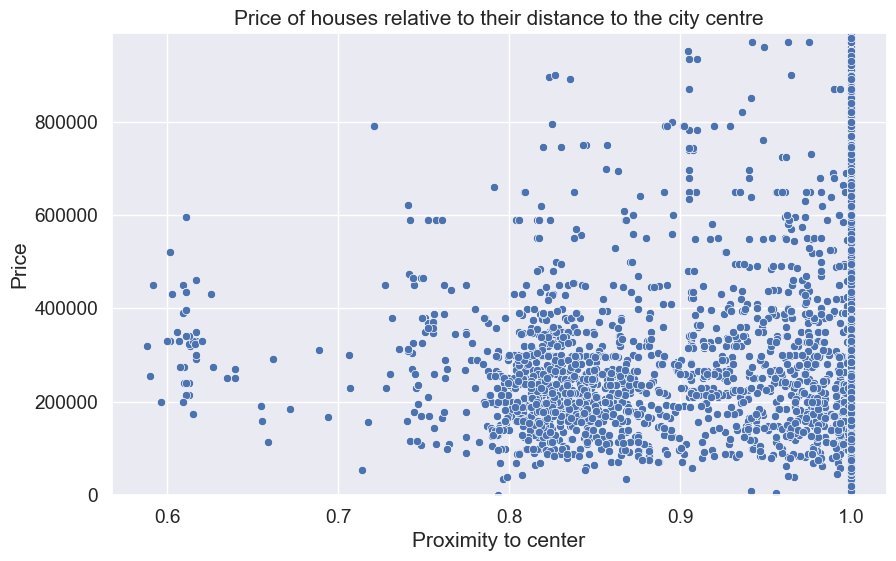

In [1936]:
# scatterplot of prices of houses relative to their proximity to the city center

data = pd.concat([df['price'], df['proximity_to_center']], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'proximity_to_center', y = 'price', data = data)
fig.axis(ymin = 0, ymax = upper_bound)
ax.set_title(r'Price of houses relative to their distance to the city centre')
ax.set_xlabel(r'Proximity to center')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

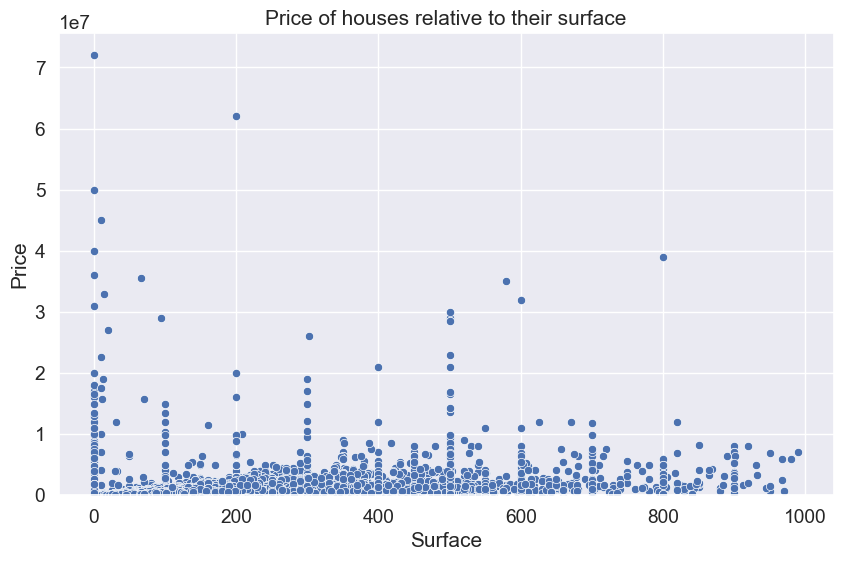

In [1937]:
# scatterplot of prices of houses relative to their surface

data = pd.concat([df['price'], df['surface']], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'surface', y = 'price', data = data)
fig.axis(ymin = 0, )
ax.set_title(r'Price of houses relative to their surface')
ax.set_xlabel(r'Surface')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

**Comments:** \
\
We notice that the number of rooms & number of bathrooms seem to be the two features which are the most correlated with the price among the features we looked at. On the other hand, the condition of the house does not seem to play a large role in determining the price, potentially alluding to the very subjective nature of the possible categories. Surface and proximity to the center also do not exhibit clear trends. These facts might be due to considering all the cities together, since location is usually correlated with the surface of the apartment (e.g., near Duomo one probably would have trouble finding a 1000 $m^2$ apartment). We will have to analyze this aspect to a deeper extent.

## Preprocessing & data cleaning

Before choosing the best features and selecting a model, we must deal with missing values and outliers. We proceed by splitting our data into train and test data. We want to avoid using any information from the test data while cleaning and processing the train data.

In [1938]:
# Split the data

from sklearn.model_selection import train_test_split

# define features and target variable
X = df.drop('price', axis=1) # features
y = df['price'] # target variable

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the shapes of the training and testing sets
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1)

X_train shape: (37049, 16)
y_train shape: (37049,)
X_test shape: (9263, 16)
y_test shape: (9263,)


In [1939]:
# preview training data

df_train.head()

,price,id,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
1133,320000,61622,NaN,Nuovo / Nuova costruzione,1960.000000,45.498243,12.248309,NaN,190.000000,1.000000,NaN,2.000000,1.000000,NaN,4.000000,1.000000,130.000000
18921,450000,13925,NaN,Buono stato / Abitabile,1986.000000,41.915600,12.387800,NaN,0.000000,0.000000,True,2.000000,NaN,3.000000,5.000000,1.000000,160.000000
36867,580000,54125,NaN,Nuovo / Nuova costruzione,2022.000000,45.486404,9.161906,NaN,50.000000,-1.000000,NaN,1.000000,NaN,NaN,1.000000,1.000000,90.000000
27541,410000,46319,True,Buono stato / Abitabile,1957.000000,41.937400,12.514400,138.800000,110.000000,2.000000,NaN,1.000000,1.000000,5.000000,3.000000,1.000000,97.000000
14421,259000,56203,True,Ottimo / Ristrutturato,2011.000000,45.472700,9.116700,22.250000,160.000000,2.000000,True,1.000000,1.000000,8.000000,2.000000,1.000000,73.000000


In [1940]:
# missing values in each column of the dataset

total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(17)

,Total,Percent
garden,25226,0.680882
energy_efficiency,15833,0.427353
total_floors,14602,0.394127
elevator,13898,0.375125
expenses,12912,0.348511
balcony,12363,0.333693
construction_year,11175,0.301628
n_bathrooms,1949,0.052606
floor,1625,0.043861
conditions,964,0.026020


The variables 'latitude', 'longitude', and 'proximity_to_center' have the same number of missing values. We verify that they correspond to the same observations, and, since the the number is very small relative to the size of the dataset, we drop the corresponding rows.

In [1941]:
# create clean dataset

df_clean = df_train.copy()

# check that the rows correspond

assert(np.all(df_clean['latitude'].isna().to_numpy() == df_clean['longitude'].isna().to_numpy()) and
np.all(df_clean['latitude'].isna().to_numpy() == df_clean['proximity_to_center'].isna().to_numpy()))

# remove the rows

df_clean = df_clean[df_clean['latitude'].notna()]
print(f"Missing observations for 'latitude': {df_clean['latitude'].isna().sum()}.")
print(f"Missing observations for 'longitude': {df_clean['longitude'].isna().sum()}.")
print(f"Missing observations for 'proximity_to_center': {df_clean['proximity_to_center'].isna().sum()}.")

Missing observations for 'latitude': 0.
Missing observations for 'longitude': 0.
Missing observations for 'proximity_to_center': 0.


The variables 'n_rooms' and 'surface' also have a relatively small number of missing observations, so we can remove the corresponding rows.

In [1942]:
# remove the rows

df_clean = df_clean[df_clean['n_rooms'].notnull()]
df_clean = df_clean[df_clean['surface'].notnull()]
print(f"Missing observations for 'n_rooms': {df_clean['n_rooms'].isna().sum()}.")
print(f"Missing observations for 'surface': {df_clean['surface'].isna().sum()}.")

Missing observations for 'n_rooms': 0.
Missing observations for 'surface': 0.


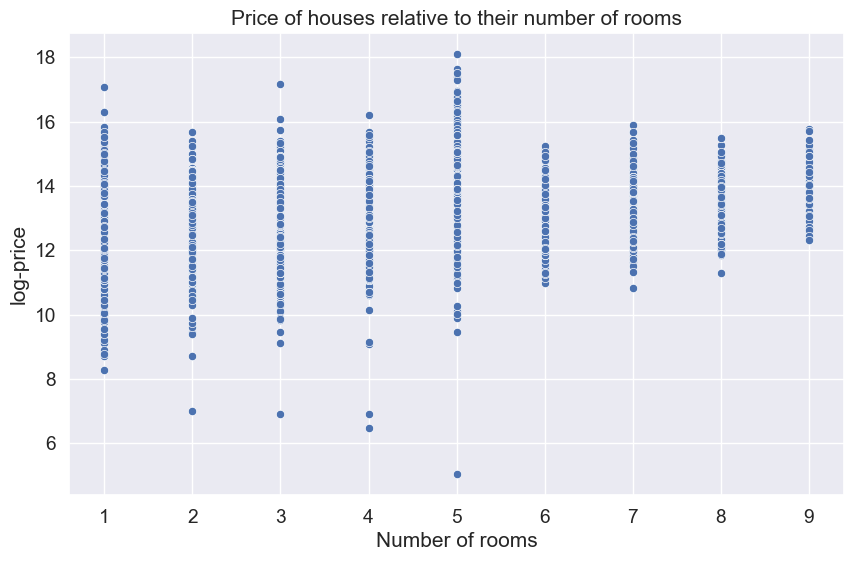

In [1943]:
# scatterplot of prices of houses relative to their number of rooms

data = pd.concat([df_clean['n_rooms'], np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'n_rooms', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to their number of rooms')
ax.set_xlabel(r'Number of rooms')
ax.set_ylabel(r'log-price')
legend = ax1.get_legend()

In [1944]:
print(f"House with 0 surface: {(df_clean['surface'] == 0).sum()}")
# Delete them
df_clean = df_clean[df_clean['surface'] > 0]
print(f"House with 0 surface after removal: {(df_clean['surface'] == 0).sum()}")

House with 0 surface: 67
House with 0 surface after removal: 0


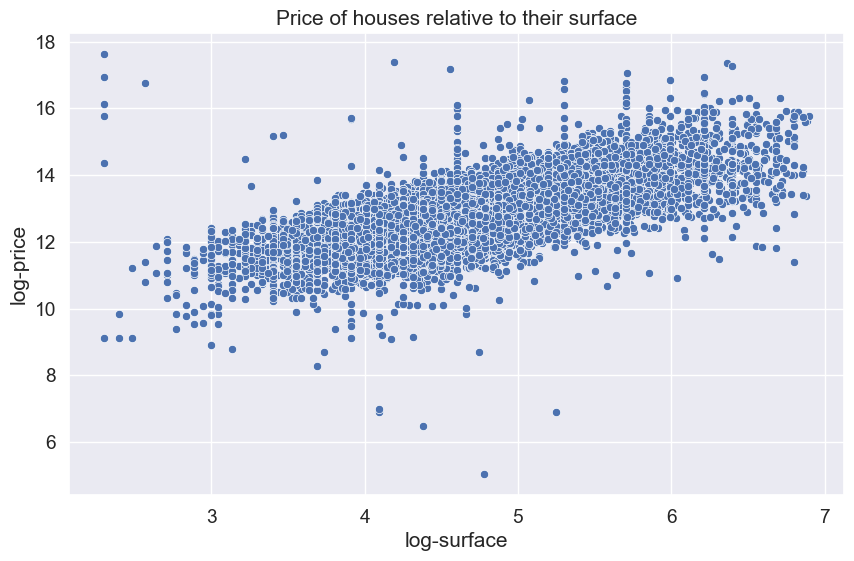

In [1945]:
# scatterplot of prices of houses relative to their surface

data = pd.concat([np.log(df_clean['surface']), np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'surface', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to their surface')
ax.set_xlabel(r'log-surface')
ax.set_ylabel(r'log-price')
legend = ax1.get_legend()

In [1946]:
print(f"Values in 'balcony': {(df_clean['balcony'].unique())}.")
print(f"Values in 'garden': {(df_clean['garden'].unique())}.")
print(f"Values in 'elevator': {(df_clean['elevator'].unique())}.")

Values in 'balcony': [nan True].
Values in 'garden': [nan True].
Values in 'elevator': [ 1. nan  0.].


For 'balcony' and 'garden it seems that the missing values correspond to False values of the features. Therefore we proceed to fill them accordingly. We also covert the variables into 1./0. to obtain proper dummy variables. The variable 'elevator', however, is not so trivial to tackle.

In [1947]:
df_clean['balcony'].fillna(0., inplace = True)
df_clean['balcony'].replace(True, 1., inplace = True)
df_clean['garden'].fillna(0., inplace = True)
df_clean['garden'].replace(True, 1., inplace = True)
print(f"Missing observations for 'balcony': {df_clean['balcony'].isna().sum()}.")
print(f"Missing observations for 'garden': {df_clean['garden'].isna().sum()}.")

Missing observations for 'balcony': 0.
Missing observations for 'garden': 0.


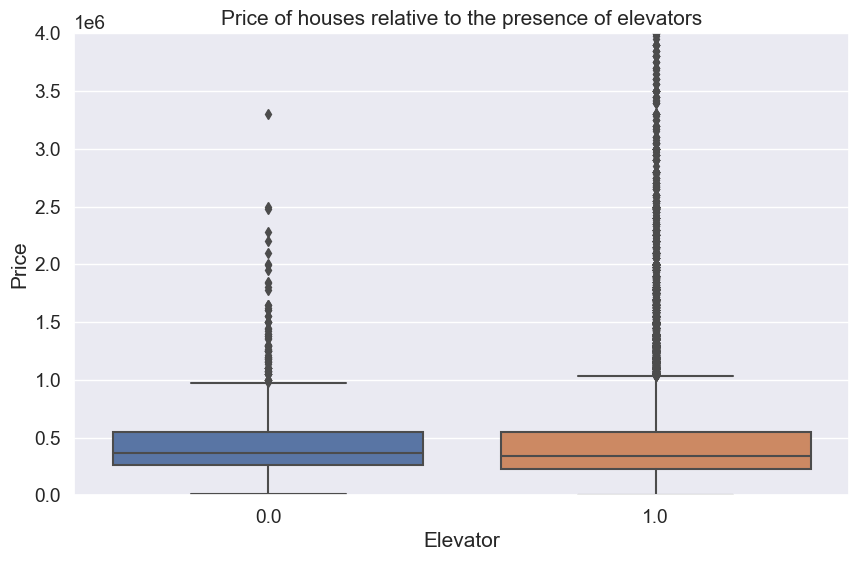

In [1948]:
# boxplot of prices with and without elevator

data = pd.concat([df_clean['price'], df_clean['elevator']], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.boxplot(x = 'elevator', y = 'price', data = data)
fig.axis(ymin = 0, ymax = 4000000)
ax.set_title(r'Price of houses relative to the presence of elevators')
ax.set_xlabel(r'Elevator')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

In [1949]:
no_elev_mean = df_clean[df_clean['elevator'] == 0]['price'].mean() # mean price without elevator
elev_mean = df_clean[df_clean['elevator'] == 1]['price'].mean() # mean price with elevator
rest_mean = df_clean[df_clean['elevator'].isna()]['price'].mean() # mean price for missing data
high_price_rest_count = sum(df_clean[df_clean['elevator'].isna()]['price'] > elev_mean) # missing rows with higher price than data with elevator
rest_mean_floor = df_clean[df_clean['elevator'].isna()]['floor'].mean() # average floor of apartments with missing data
print(f"Mean price without elevator: {no_elev_mean}.")
print(f"Mean price with elevator: {elev_mean}.")
print(f"Mean price of missing observation: {rest_mean}.")
print(f"Number of expensive homes of missing observations: {high_price_rest_count}.")
print(f"Average floor of missing observations: {rest_mean_floor}.")

Mean price without elevator: 459860.730941704.
Mean price with elevator: 500988.2779986292.
Mean price of missing observation: 442223.83775877586.
Number of expensive homes of missing observations: 2743.
Average floor of missing observations: 1.2011089961102375.


There is significant empirical evidence to suggest that the missing observations could be regarded as not having an elevator, since this would be consistent with the means of the two clusters, as well as with common sense: since the average floor for these data is 1.2, we can assume an elevator is not needed. We therefore set the missing values to 0.

In [1950]:
df_clean.loc[df_clean['elevator'].isna(), 'elevator'] = 0
print(f"Missing observations for 'elevator': {df_clean['elevator'].isna().sum()}.")

Missing observations for 'elevator': 0.


We now move to 'energy_efficiency':

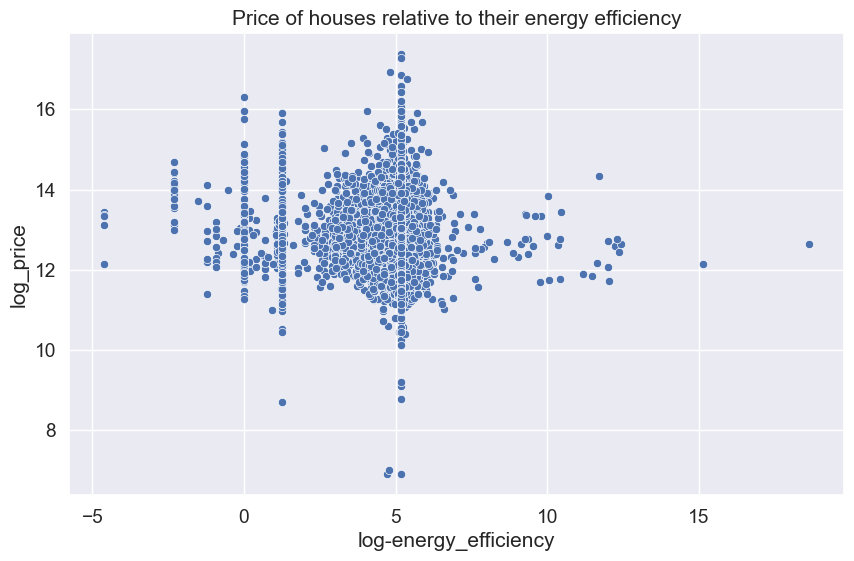

In [1951]:
# scatterplot of prices of houses relative to their energy efficiency

data = pd.concat([np.log(df_clean['energy_efficiency']), np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'energy_efficiency', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to their energy efficiency')
ax.set_xlabel(r'log-energy_efficiency')
ax.set_ylabel(r'log_price')
legend = ax1.get_legend()

In [1952]:
Q1 = np.quantile(df_clean[df_clean['energy_efficiency'].notnull()]['energy_efficiency'], 0.25)
Q3 = np.quantile(df_clean[df_clean['energy_efficiency'].notnull()]['energy_efficiency'], 0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(sum(df_clean['energy_efficiency'] > upper_bound)) # total outliers

1688


In [1953]:
print(df_clean.sort_values('energy_efficiency', ascending=False)['energy_efficiency'])

8236    123457000.000000
43977     3727500.000000
15424      252367.000000
45044      233250.000000
36788      222222.000000
              ...       
1685                 NaN
16023                NaN
44131                NaN
6265                 NaN
44732                NaN
Name: energy_efficiency, Length: 36332, dtype: float64


In [1954]:
# We want to remove the first two larget values since they are significantly larger than the others

rest_mean = np.mean(sorted(df_clean[df_clean['energy_efficiency'].notna()]['energy_efficiency'])[:-2])
df_clean = df_clean.sort_values('energy_efficiency', ascending=False).iloc[2:]

In [1955]:
df_clean['energy_efficiency'].describe()

count    20791.000000
mean       259.241575
std       4043.667113
min          0.010000
25%        160.000000
50%        175.000000
75%        175.000000
max     252367.000000
Name: energy_efficiency, dtype: float64

In [1956]:
# We now fill the missing values with the mean

rest_mean = np.mean(df_clean[df_clean['energy_efficiency'].notna()]['energy_efficiency'])
df_clean.loc[df_clean['energy_efficiency'].isna(), 'energy_efficiency'] = rest_mean
print(f"Missing observations for 'energy_efficiency': {df_clean['elevator'].isna().sum()}.")

Missing observations for 'energy_efficiency': 0.


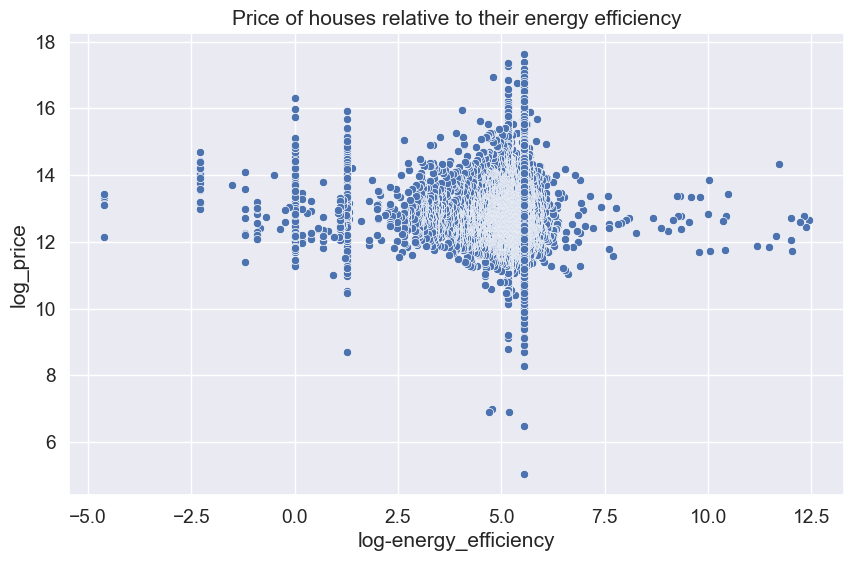

In [1957]:
# scatterplot of prices of houses relative to their energy efficiency

data = pd.concat([np.log(df_clean['energy_efficiency']), np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'energy_efficiency', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to their energy efficiency')
ax.set_xlabel(r'log-energy_efficiency')
ax.set_ylabel(r'log_price')
legend = ax1.get_legend()

We analyze the variable 'expenses':

In [1958]:
df_aux = df_clean.copy

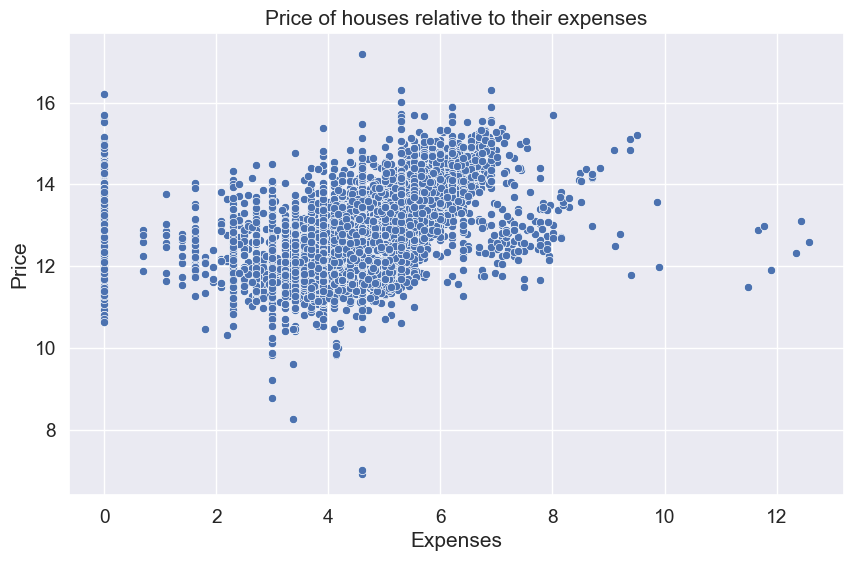

In [1959]:
# scatterplot of prices of houses relative to their expenses

data = pd.concat([np.log(df_clean['expenses']), np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'expenses', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to their expenses')
ax.set_xlabel(r'Expenses')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

In [1960]:
Q1 = np.quantile(df_clean[df_clean['expenses'].notnull()]['expenses'], 0.25)
Q3 = np.quantile(df_clean[df_clean['expenses'].notnull()]['expenses'], 0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(sum(df_clean['expenses'] > upper_bound)) # total outliers -> too many to remove

1433


In [1961]:
np.log(df_clean[df_clean['expenses'].notnull()]['expenses'])

15424   4.174387
45044   4.382027
36788   5.298317
35787   4.110874
17412   3.912023
          ...   
41434   4.442651
39188   3.912023
1685    5.298317
16023   3.401197
44131   3.688879
Name: expenses, Length: 24025, dtype: float64

In [1962]:
vals = df_clean[df_clean['expenses'].notnull()]['expenses']
log_expenses_mean = np.log(vals[vals >= 10]).mean()
log_expenses_std = np.log(vals[vals >= 10]).std()
print(f"mean: {log_expenses_mean}, variance: {log_expenses_std}")

mean: 4.5815351042513015, variance: 0.8427707126377116


In [1963]:
print(df_clean.sort_values('expenses', ascending=False)['expenses'].head(20))

45642   290000.000000
13646   250000.000000
31365   230000.000000
24365   148000.000000
15664   130144.000000
24020   116000.000000
36472    98000.000000
27035    20000.000000
3847     19167.000000
26243    13500.000000
21528    12012.000000
20024    12000.000000
36123    12000.000000
36753    10000.000000
33655     9033.000000
16366     9000.000000
31427     7000.000000
16678     6000.000000
42504     6000.000000
29694     6000.000000
Name: expenses, dtype: float64


In [1964]:
# lower outliers

n_outliers = (df_clean['expenses'] < 10).sum()

print(f"Houses with expenses less than 10: {n_outliers}") # too many to delete

# fill them with random uniform values in (10, upper_bound)

df_clean.loc[df_clean['expenses'] < 10, 'expenses'] = np.exp(np.random.normal(log_expenses_mean, log_expenses_std, size=n_outliers))
print(f"Houses with expenses less than 10 after imputation: {(df_clean['expenses'] < 10).sum()}")

Houses with expenses less than 10: 3921
Houses with expenses less than 10 after imputation: 20


In [1965]:
# upper outliers
n_outliers = (df_clean['expenses'] > np.exp(8)).sum()

print(f"Upper outliers: {n_outliers}") # too many to delete

# fill them with random values 

df_clean.loc[df_clean['expenses'] > np.exp(8), 'expenses'] = np.exp(np.random.normal(log_expenses_mean, log_expenses_std, size=n_outliers))
print(f"Upper outliers after imputation: {(df_clean['expenses'] > np.exp(8)).sum()}")

Upper outliers: 42
Upper outliers after imputation: 0


In [1966]:
df_clean['expenses'].describe()

count   24025.000000
mean      138.696967
std       167.067164
min         3.213871
25%        56.315990
50%       100.000000
75%       165.000000
max      2850.000000
Name: expenses, dtype: float64

In [1967]:
# We now fill the missing values with random uniform values in (10, upper_bound)

n_missing = df_clean['expenses'].isna().sum()

#df_clean.loc[df_clean['expenses'].isna(), 'expenses'] = np.exp(np.random.normal(log_expenses_mean, log_expenses_std, size=n_missing))
df_clean.loc[df_clean['expenses'].isna(), 'expenses'] = df_clean['expenses'].mean()
print(f"Missing observations for 'expenses': {df_clean['expenses'].isna().sum()}.")

Missing observations for 'expenses': 0.


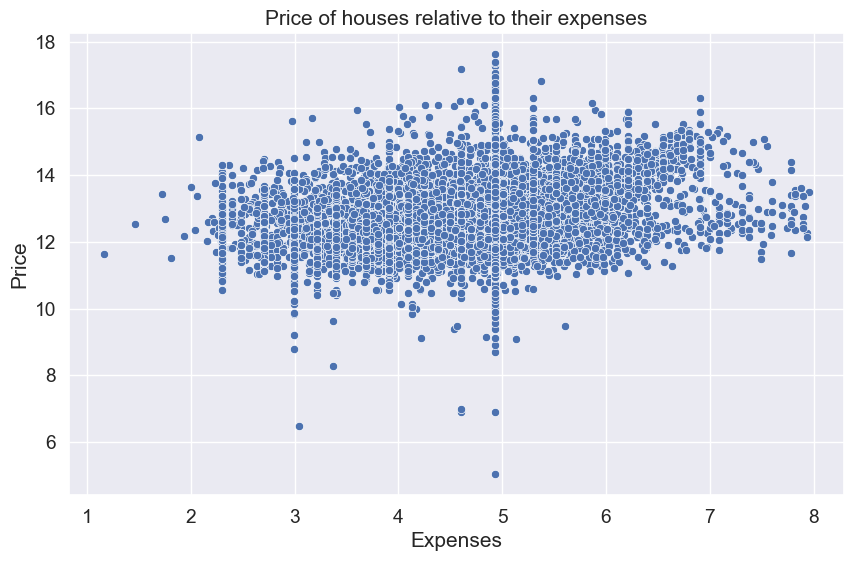

In [1968]:
# scatterplot of prices of houses relative to their expenses

data = pd.concat([np.log(df_clean['expenses']), np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'expenses', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to their expenses')
ax.set_xlabel(r'Expenses')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

In [1969]:
np.corrcoef(np.log(df_clean['price']), np.log(df_clean['expenses']))

array([[1.        , 0.35711995],
       [0.35711995, 1.        ]])

We move to the variable 'total_floors':

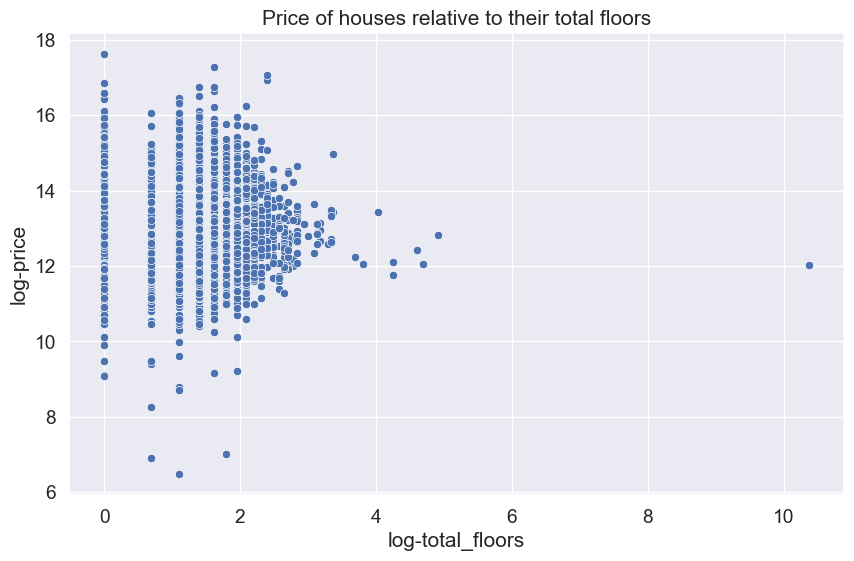

In [1970]:
# scatterplot of prices of houses relative to their total floors

data = pd.concat([np.log(df_clean['total_floors']), np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'total_floors', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to their total floors')
ax.set_xlabel(r'log-total_floors')
ax.set_ylabel(r'log-price')
legend = ax1.get_legend()

In [1971]:
# We simply delete the outlier

df_clean = df_clean[df_clean['total_floors'] != df_clean['total_floors'].max()]

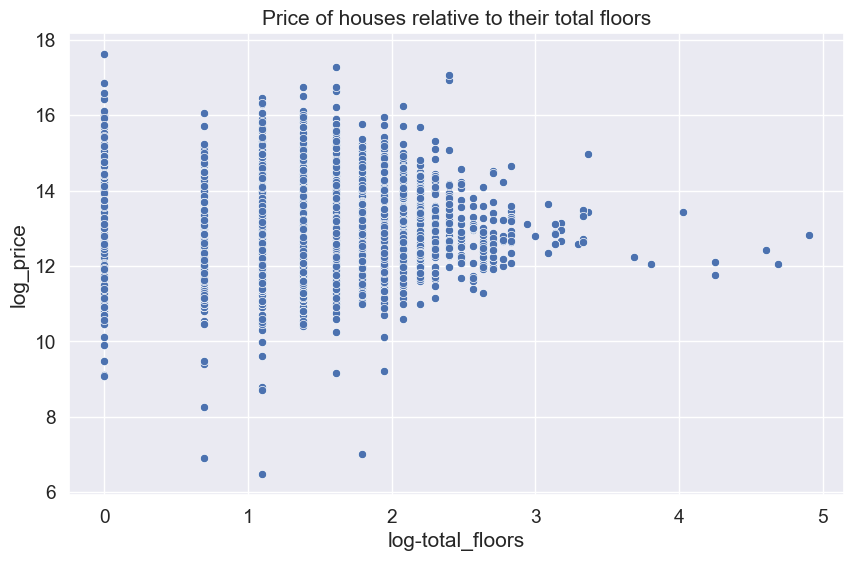

In [1972]:
# scatterplot of prices of houses relative to their total floors

data = pd.concat([np.log(df_clean['total_floors']), np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'total_floors', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to their total floors')
ax.set_xlabel(r'log-total_floors')
ax.set_ylabel(r'log_price')
legend = ax1.get_legend()

In [1973]:
df_clean['total_floors'].describe()

count   21945.000000
mean        4.565277
std         2.703635
min         1.000000
25%         3.000000
50%         4.000000
75%         6.000000
max       135.000000
Name: total_floors, dtype: float64

In [1974]:
# We now fill the missing values with the maximum between the median of 'total_floors' and the value in 'floor'

median_total_floors = df_clean['total_floors'].median()
df_clean['total_floors'] = df_clean.apply(lambda row: max(median_total_floors, row['floor']) if pd.isna(row['total_floors']) else row['total_floors'], axis=1)
print(f"Missing observations for 'total_floors': {df_clean['total_floors'].isna().sum()}.")

Missing observations for 'total_floors': 0.


We proceed to 'construction_year'. Altough it is not clear what a suitable replacement for the missing values could be, we propose the median construction year.

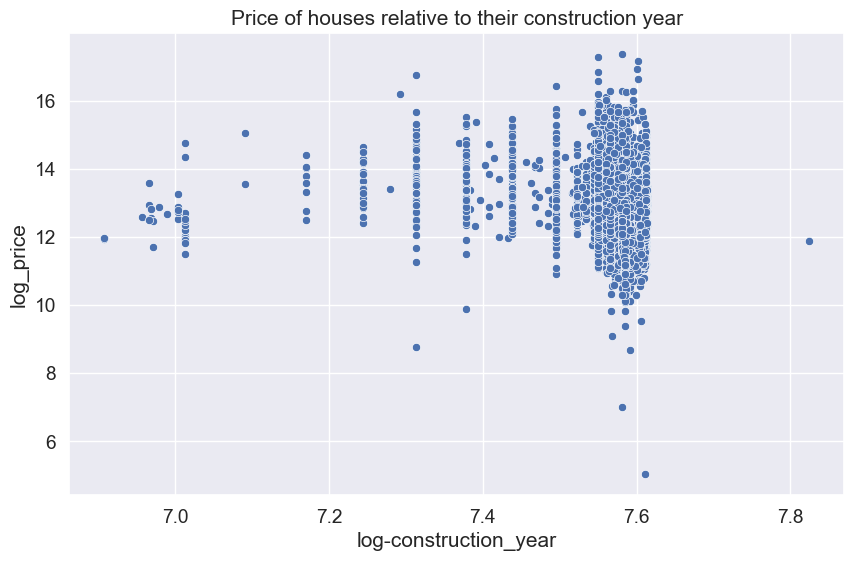

In [1975]:
# scatterplot of prices of houses relative to their construction year

data = pd.concat([np.log(df_clean['construction_year']), np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'construction_year', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to their construction year')
ax.set_xlabel(r'log-construction_year')
ax.set_ylabel(r'log_price')
legend = ax1.get_legend()

In [1976]:
# we remove the lower outlier

df_clean = df_clean[df_clean['construction_year'] != df_clean['construction_year'].min()]

In [1977]:
# we deal with the upper outliers (we assume that everything that is greater than 2023 is recent, so we replace it with 2023)

df_clean['construction_year'] = df_clean['construction_year'].apply(lambda year: min(year, 2023))

In [1978]:
df_clean['construction_year'].describe()

count   25727.000000
mean     1958.197225
std        71.282147
min      1050.000000
25%      1950.000000
50%      1966.000000
75%      1987.000000
max      2023.000000
Name: construction_year, dtype: float64

In [1979]:
median_construction_year = df_clean['construction_year'].median()
df_clean['construction_year'] = df_clean['construction_year'].fillna(median_construction_year)
print(f"Missing observations for 'construction_year': {df_clean['construction_year'].isna().sum()}.")

Missing observations for 'construction_year': 0.


For 'number_of_bathrooms' we proceed in the following way:

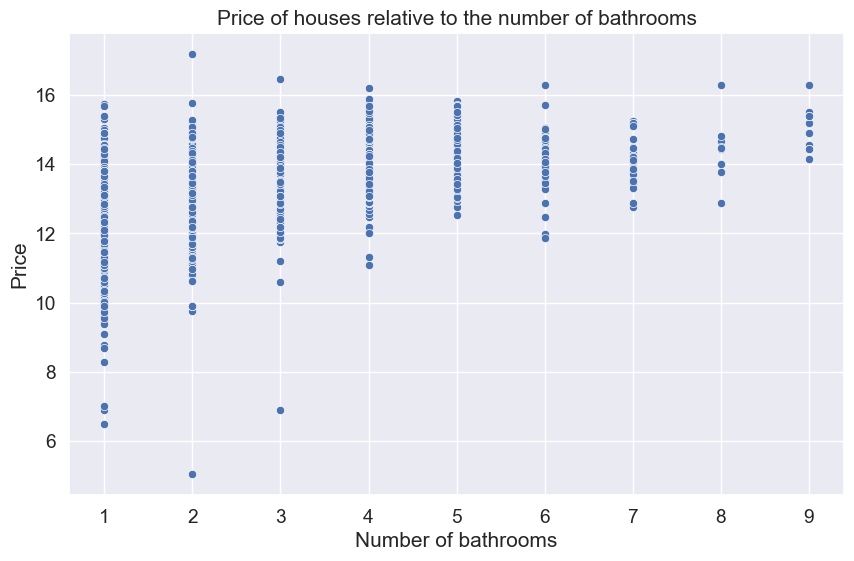

In [1980]:
# scatterplot of prices of houses relative to the number of bathrooms

data = pd.concat([df_clean['n_bathrooms'], np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'n_bathrooms', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to the number of bathrooms')
ax.set_xlabel(r'Number of bathrooms')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

In [1981]:
df_clean['n_bathrooms'].describe()

count   34718.000000
mean        1.555706
std         0.766890
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: n_bathrooms, dtype: float64

In [1982]:
# We fill the missing values with the median

df_clean.loc[df_clean['n_bathrooms'].isna(), 'n_bathrooms'] = df_clean['n_bathrooms'].median()

print(f"Missing observations for 'n_bathrooms': {df_clean['n_bathrooms'].isna().sum()}.")

Missing observations for 'n_bathrooms': 0.


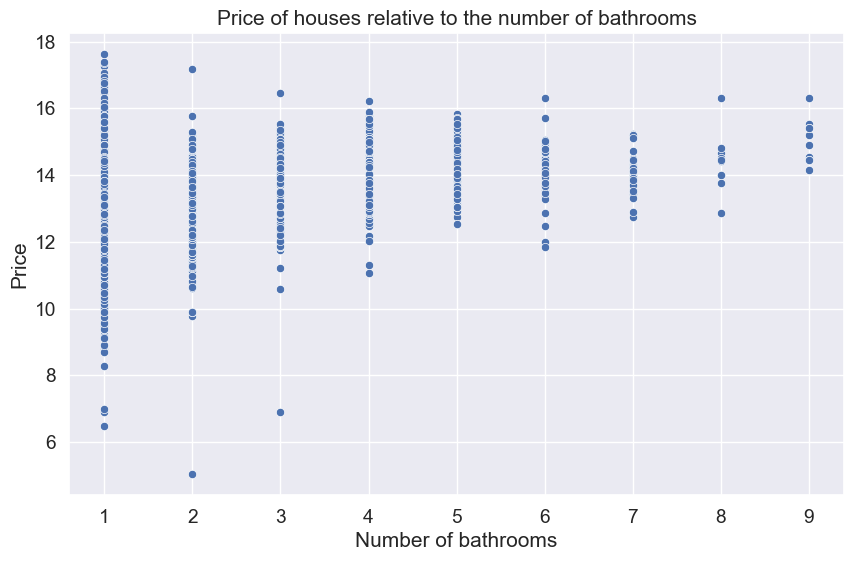

In [1983]:
# scatterplot of prices of houses relative to the number of bathrooms

data = pd.concat([df_clean['n_bathrooms'], np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'n_bathrooms', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to the number of bathrooms')
ax.set_xlabel(r'Number of bathrooms')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

We now move to 'floor':

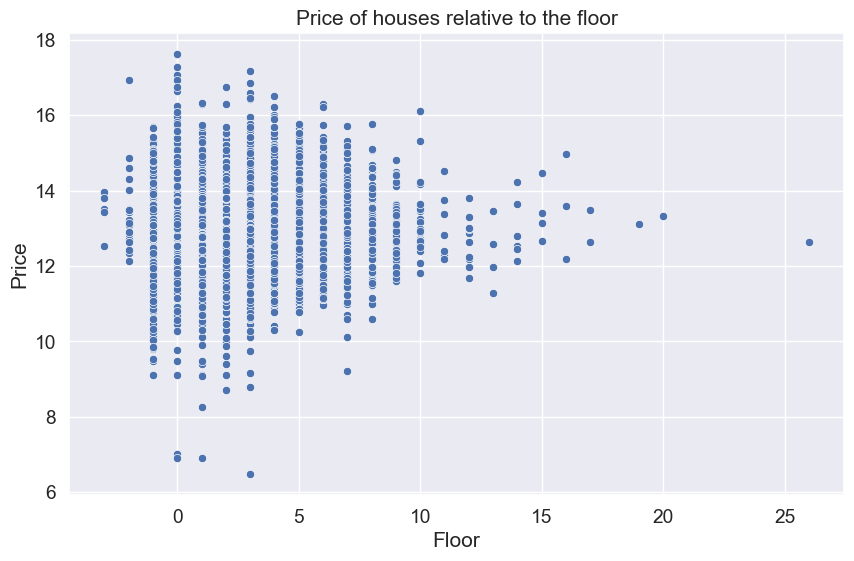

In [1984]:
# scatterplot of prices of houses relative to the floor

data = pd.concat([df_clean['floor'], np.log(df_clean['price'])], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.scatterplot(x = 'floor', y = 'price', data = data)
#fig.axis(xmin = -500, xmax = 10000, ymin = -10000)
ax.set_title(r'Price of houses relative to the floor')
ax.set_xlabel(r'Floor')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

In [1985]:
# Sanity check: ensure that the floor is not greater than the number of floors

df_clean.loc[df_clean['floor'] > df_clean['total_floors'], 'floor'] = df_clean['total_floors']

In [1986]:
df_clean['floor'].describe()

count   34813.000000
mean        2.019705
std         2.152911
min        -3.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        26.000000
Name: floor, dtype: float64

In [1987]:
# Fill the missing values with the median

median_floor = df_clean['floor'].median()
df_clean['floor'] = df_clean['floor'].fillna(median_floor)
print(f"Missing observations for 'floor': {df_clean['floor'].isna().sum()}.")

Missing observations for 'floor': 0.


Finally, we take care of 'conditions':

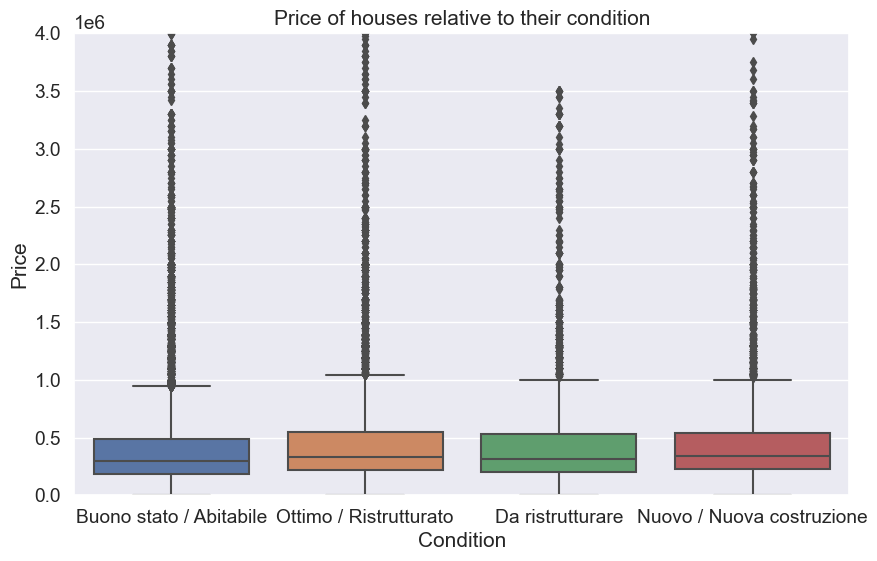

In [1988]:
# boxplot of prices of houses relative to their condition
data = pd.concat([df_clean['price'], df_clean['conditions']], axis = 1)
f, ax = plt.subplots(figsize = (10, 6))
fig = sns.boxplot(x = 'conditions', y = 'price', data = data)
fig.axis(ymin = 0, ymax = 4000000)
ax.set_title(r'Price of houses relative to their condition')
ax.set_xlabel(r'Condition')
ax.set_ylabel(r'Price')
legend = ax1.get_legend()

In [1989]:
# Compute how many observations fall within each category

condition_counts = df_clean['conditions'].value_counts()
print("Number of observations in each category of 'conditions':\n")
print(condition_counts)

Number of observations in each category of 'conditions':

conditions
Buono stato / Abitabile      16990
Ottimo / Ristrutturato        8436
Nuovo / Nuova costruzione     5609
Da ristrutturare              4429
Name: count, dtype: int64


In [1990]:
# We asign the missing values to the most popular category

df_clean['conditions'].fillna(value='Buono stato / Abitabile', inplace=True)
print(f"Missing observations for 'conditions': {df_clean['conditions'].isna().sum()}.")

Missing observations for 'conditions': 0.


We would like to transform the 'conditions' variable so that it can be used for regression. Our choice is a one-hot encoding, thereby replacing the initial column with 4 columns that contain 1s and 0s depending on the respective condition of a house.

In [1991]:
# perform one-hot encoding
conditions_onehot = pd.get_dummies(df_clean['conditions'], dtype = float)

# merge the encoded columns with the original dataframe
df_clean = pd.concat([df_clean, conditions_onehot], axis=1)

# drop the original 'conditions' column
df_clean = df_clean.drop('conditions', axis=1)

# inspect the dataset
df_clean.head()

,price,id,balcony,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,Buono stato / Abitabile,Da ristrutturare,Nuovo / Nuova costruzione,Ottimo / Ristrutturato
15424,310000,4947,1.000000,1970.000000,41.960285,12.523299,252367.000000,65.000000,3.000000,1.000000,1.000000,1.000000,4.000000,2.000000,1.000000,73.000000,1.000000,0.000000,0.000000,0.000000
45044,255000,61321,0.000000,1930.000000,45.492519,9.225300,233250.000000,80.000000,1.000000,1.000000,1.000000,0.000000,5.000000,2.000000,1.000000,55.000000,1.000000,0.000000,0.000000,0.000000
36788,350000,2746,1.000000,2000.000000,45.530491,9.162390,222222.000000,200.000000,5.000000,0.000000,2.000000,1.000000,6.000000,3.000000,1.000000,115.000000,0.000000,0.000000,0.000000,1.000000
11783,295000,18742,1.000000,1966.000000,45.436489,12.342140,203660.000000,138.696967,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,1.000000,65.000000,1.000000,0.000000,0.000000,0.000000
40823,123000,48400,1.000000,1978.000000,45.495010,12.231330,167050.000000,138.696967,2.000000,1.000000,1.000000,0.000000,4.000000,5.000000,1.000000,81.000000,0.000000,0.000000,0.000000,1.000000


In [1992]:
# Verify that there are no missing values

total = df_clean.isnull().sum().sort_values(ascending=False)
percent = (df_clean.isnull().sum()/df_clean.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
price,0,0.000000
id,0,0.000000
Nuovo / Nuova costruzione,0,0.000000
Da ristrutturare,0,0.000000
Buono stato / Abitabile,0,0.000000
surface,0,0.000000
proximity_to_center,0,0.000000
n_rooms,0,0.000000
total_floors,0,0.000000
elevator,0,0.000000


Indeed, we managed to remove all missing values and now our data are ready for regularization and feature selection.

In [1993]:
print(f"Number of rows in original dataframe: {df_train.shape[0]}.")
print(f"Number of columns in original dataframe: {df_train.shape[1]}.")
print(f"Number of rows in cleaned dataframe: {df_clean.shape[0]}.")
print(f"Number of columns in cleaned dataframe: {df_clean.shape[1]}.")
print(f"Number of rows dropped: {df_train.shape[0] - df_clean.shape[0]}.")

Number of rows in original dataframe: 37049.
Number of columns in original dataframe: 17.
Number of rows in cleaned dataframe: 36327.
Number of columns in cleaned dataframe: 20.
Number of rows dropped: 722.


We only lost 727 rows and we eneded up with three extra columns, for a total of 20 features. We can thus proceed with feature selection.

## Target variable distribution

Our target variable is highly skewed. A good transformation which minimizes the skewness of the original data is the log transform, which makes the distribution resemble a Gaussian.

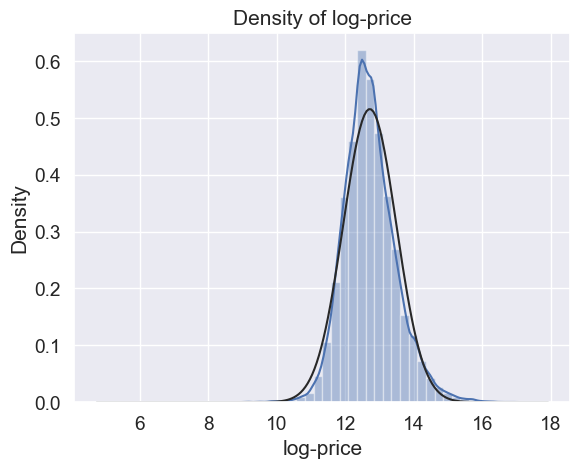

In [1995]:
# log-price density is close to normal -> good

fig, ax = plt.subplots()
log_price = np.log(df_clean['price'])
sns.distplot(log_price, fit=norm)
ax.set_title(r'Density of log-price')
ax.set_xlabel(r'log-price')
ax.set_ylabel(r'Density')
legend = ax1.get_legend()

Indeed, this seems to be good enough for our analysis. We will transform the other variables when performing feature selection.

## Clustering by city

In real estate, location is everything. We focus on this aspect now. We want to group the houses by city, since we expect differences in prices across different location. To achieve this, we use KMeans clustering and then we plot the cities on the map to verify our analysis.

In [1996]:
df_clean.reset_index(drop = True)

,price,id,balcony,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,Buono stato / Abitabile,Da ristrutturare,Nuovo / Nuova costruzione,Ottimo / Ristrutturato
15424,310000,4947,1.000000,1970.000000,41.960285,12.523299,252367.000000,65.000000,3.000000,1.000000,1.000000,1.000000,4.000000,2.000000,1.000000,73.000000,1.000000,0.000000,0.000000,0.000000
45044,255000,61321,0.000000,1930.000000,45.492519,9.225300,233250.000000,80.000000,1.000000,1.000000,1.000000,0.000000,5.000000,2.000000,1.000000,55.000000,1.000000,0.000000,0.000000,0.000000
36788,350000,2746,1.000000,2000.000000,45.530491,9.162390,222222.000000,200.000000,5.000000,0.000000,2.000000,1.000000,6.000000,3.000000,1.000000,115.000000,0.000000,0.000000,0.000000,1.000000
11783,295000,18742,1.000000,1966.000000,45.436489,12.342140,203660.000000,138.696967,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,1.000000,65.000000,1.000000,0.000000,0.000000,0.000000
40823,123000,48400,1.000000,1978.000000,45.495010,12.231330,167050.000000,138.696967,2.000000,1.000000,1.000000,0.000000,4.000000,5.000000,1.000000,81.000000,0.000000,0.000000,0.000000,1.000000


In [1997]:
# Perform the clustering

from sklearn.cluster import KMeans

# Extract the latitude and longitude values from the DataFrame
X = df_clean[['latitude', 'longitude']].values

# Perform K-means clustering with three clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
y_kmeans = kmeans.fit_predict(X)

In [1998]:
# Transform clusters into labeled cities

df_clean['Roma'] = (y_kmeans == 1).astype(int)
df_clean['Milano'] = (y_kmeans == 0).astype(int)
df_clean['Venezia'] = (y_kmeans == 2).astype(int)

In [1999]:
# Make sure notebook is trusted to see the plot

import folium

italy_map = folium.Map(location=[42.8333, 12.8333], zoom_start=6)

# Define the colors for the clusters
colors = ['red', 'blue', 'green']

# Loop through the data and add markers to the map
k = 0
for index, row in df_clean.iterrows():
    k += 1
    lat = df_train_unscaled[df_train_unscaled['id'] == row['id']]['latitude']
    lon = df_train_unscaled[df_train_unscaled['id'] == row['id']]['longitude']
    if row['Roma'] == 1:
        color = 'red'
        city = 'Roma'
    elif row['Milano'] == 1:
        color = 'blue'
        city = 'Milano'
    else:
        color = 'green'
        city = 'Venezia'
    tooltip = f"{city}"
    folium.Marker([lat, lon], tooltip=tooltip, icon=folium.Icon(color=color)).add_to(italy_map)
    if k == 100:
        break

# Display the map
italy_map

In [2000]:
print(f"Average price in Rome: {df_train_unscaled[df_train_unscaled['Roma'] == 1]['price'].mean()}.")
print(f"Average price in Milan: {df_train_unscaled[df_train_unscaled['Milano'] == 1]['price'].mean()}.")
print(f"Average price in Venice: {df_train_unscaled[df_train_unscaled['Venezia'] == 1]['price'].mean()}.")

Average price in Rome: 436204.305246341.
Average price in Milan: 576669.9897146946.
Average price in Venice: 428381.5552072449.


Indeed, Milan seems to have much more expensive average homes relative to Rome and Venice.

## Test data preparation

We now prepare the test data to use for validation of our models.

In [2001]:
# Cleaning function for test data

def prepare_test_data(df_test):
    # Fill missing values
    
    data = df_test.copy()
    
    data['balcony'] = data['balcony'].fillna(0)
    data['balcony'] = data['balcony'].replace(True, 1)
    
    data['conditions'].fillna(value='Buono stato / Abitabile', inplace=True)
    conditions_onehot = pd.get_dummies(data['conditions'], dtype = float)
    data = pd.concat([data, conditions_onehot], axis=1)
    data = data.drop('conditions', axis=1)
    
    data['construction_year'] = data['construction_year'].fillna(data['construction_year'].median())
    
    data['latitude'] = data['latitude'].fillna(41.9028)
    data['longitude'] = data['longitude'].fillna(12.496366)
    data['proximity_to_center'] = data['proximity_to_center'].fillna(data['proximity_to_center'].mean())
    
    data['energy_efficiency'] = data['energy_efficiency'].fillna(data['energy_efficiency'].mean())
    
    vals = data[data['expenses'].notnull()]['expenses']
    log_expenses_mean = np.log(vals[vals >= 10]).mean()
    log_expenses_std = np.log(vals[vals >= 10]).std()
    n_outliers = (data['expenses'] < 10).sum()
    data.loc[data['expenses'] < 10, 'expenses'] = np.exp(np.random.normal(log_expenses_mean, log_expenses_std, size=n_outliers))
    n_outliers = (data['expenses'] > np.exp(8)).sum()
    data.loc[data['expenses'] > np.exp(8), 'expenses'] = np.exp(np.random.normal(log_expenses_mean, log_expenses_std, size=n_outliers))
    data['expenses'] = data['expenses'].fillna(data['expenses'].mean())
    
    data['floor'] = data['floor'].fillna(data['floor'].median())
    
    data['garden'] = data['garden'].fillna(0)
    data['garden'] = data['garden'].replace(True, 1)
    
    data['n_bathrooms'] = data['n_bathrooms'].fillna(data['n_bathrooms'].median())
    
    data['elevator'] = data['elevator'].fillna(0)
    
    median_total_floors = data['total_floors'].median()
    data['total_floors'] = data.apply(lambda row: max(median_total_floors, row['floor']) if pd.isna(row['total_floors']) else row['total_floors'], axis=1)
    
    data['n_rooms'] = data['n_rooms'].fillna(data['n_rooms'].median())
    
    data['proximity_to_center'] = data['proximity_to_center'].fillna(data['proximity_to_center'].mean())
    
    data['surface'] = data['surface'].fillna(data['surface'].mean())
    data.loc[data['surface'] == 0, 'surface'] = data['surface'].mean()
    
    # Add the cities
    
    X = data[['latitude', 'longitude']]
    
    y_kmeans = kmeans.fit_predict(X)
    data['Roma'] = (y_kmeans == 1).astype(int)
    data['Milano'] = (y_kmeans == 2).astype(int)
    data['Venezia'] = (y_kmeans == 0).astype(int)

    # Reset the index
    data = data.reset_index(drop=True)
    
    return data

In [2002]:
# Apply the cleaning function

est_out = prepare_test_data(df_test)

In [2003]:
# Preview the data

test_out.head()

,price,id,balcony,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,...,n_rooms,proximity_to_center,surface,Buono stato / Abitabile,Da ristrutturare,Nuovo / Nuova costruzione,Ottimo / Ristrutturato,Roma,Milano,Venezia
0,640000,41113,0,1967.000000,45.460700,9.185200,175.000000,250.000000,1.000000,0,...,2.000000,1.000000,69.000000,0.000000,0.000000,0.000000,1.000000,0,1,0
1,380000,61518,1,1967.000000,45.449145,9.143510,290.463930,137.482293,1.000000,0,...,3.000000,1.000000,140.000000,0.000000,1.000000,0.000000,0.000000,0,1,0
2,200000,30416,0,1967.000000,41.930749,12.520244,186.910000,137.482293,2.000000,0,...,2.000000,1.000000,75.000000,1.000000,0.000000,0.000000,0.000000,1,0,0
3,639000,52738,0,1987.000000,41.845218,12.330052,290.463930,137.482293,2.000000,0,...,5.000000,1.000000,970.000000,0.000000,1.000000,0.000000,0.000000,1,0,0
4,169000,15736,1,2020.000000,41.917105,12.556276,290.463930,50.000000,1.000000,1,...,1.000000,1.000000,40.000000,1.000000,0.000000,0.000000,0.000000,1,0,0


In [2004]:
# Make sure notebook is 'trusted' to see the plot

italy_map = folium.Map(location=[42.8333, 12.8333], zoom_start=6)

# Define the colors for the clusters
colors = ['red', 'blue', 'green']

# Loop through the data and add markers to the map
k = 0
for index, row in test_out.iterrows():
    k += 1
    lat = test_out[test_out['id'] == row['id']]['latitude']
    lon = test_out[test_out['id'] == row['id']]['longitude']
    if row['Roma'] == 1:
        color = 'red'
        city = 'Roma'
    elif row['Milano'] == 1:
        color = 'blue'
        city = 'Milano'
    else:
        color = 'green'
        city = 'Venezia'
    tooltip = f"{city}"
    folium.Marker([lat, lon], tooltip=tooltip, icon=folium.Icon(color=color)).add_to(italy_map)
    if k == 100:
        break

# Display the map
italy_map

## Features & correlations

We take a look at the features in our cleaned training data to observe their correlations. To improve these correlations, we look for the most suitable transformations, as well as for potentially new features.

In [2005]:
df_corr = df_clean.copy()
df_corr['price'] = np.log(df_corr['price'])

df_t = test_out.copy()
df_t['price'] = np.log(df_t['price'])

We expect the price of a house to be similar to the prices of houses in its neighbourhood. We therefore look for the average price of the nearest houses and add it to our features, by **creating a new column: 'avg_price'**. To do this efficiently, we use a K-d tree from scipy.

In [2006]:
from scipy.spatial import cKDTree # needed for efficiently running the queries

# create a KDTree from the latitude and longitude columns
tree = cKDTree(df_corr[['latitude', 'longitude']])

# query the tree to find the closest neighbors for each point
distances, indices = tree.query(df_corr[['latitude', 'longitude']], k=201)

# compute the average price of the closest neighbors for each point
avg_prices = []
for i in range(len(indices)):
    # remove the index of the point itself from the list of indices
    neighbors = indices[i][1:]
    # get the prices of the closest neighbors
    prices = df_corr.iloc[neighbors]['price']
    # compute the average price
    avg_price = prices.mean()
    avg_prices.append(avg_price)

# add the new column to the dataframe
df_corr['avg_price'] = avg_prices

In [2007]:
# create a KD-tree based on the latitude and longitude
tree = cKDTree(df_corr[['latitude', 'longitude']])

# query the KD-tree to find the 100 closest houses for each row in test_out
distances, indices = tree.query(df_t[['latitude', 'longitude']], k=201)

avg_prices = []
for i in range(len(indices)):
    # remove the index of the point itself from the list of indices
    neighbors = indices[i][1:]
    # get the prices of the closest neighbors
    prices = df_corr.iloc[neighbors]['price']
    # compute the average price
    avg_price = prices.mean()
    avg_prices.append(avg_price)

# calculate the average price of the closest 50 houses for each row in test_out
df_t['avg_price'] = avg_prices

In [2008]:
df_corr['surface'] = np.log(df_clean['surface'])
df_t['surface'] = np.log(test_out['surface'])

In [2009]:
df_corr['expenses'] = np.log(df_clean['expenses'])
df_t['expenses'] = np.log(test_out['expenses'])

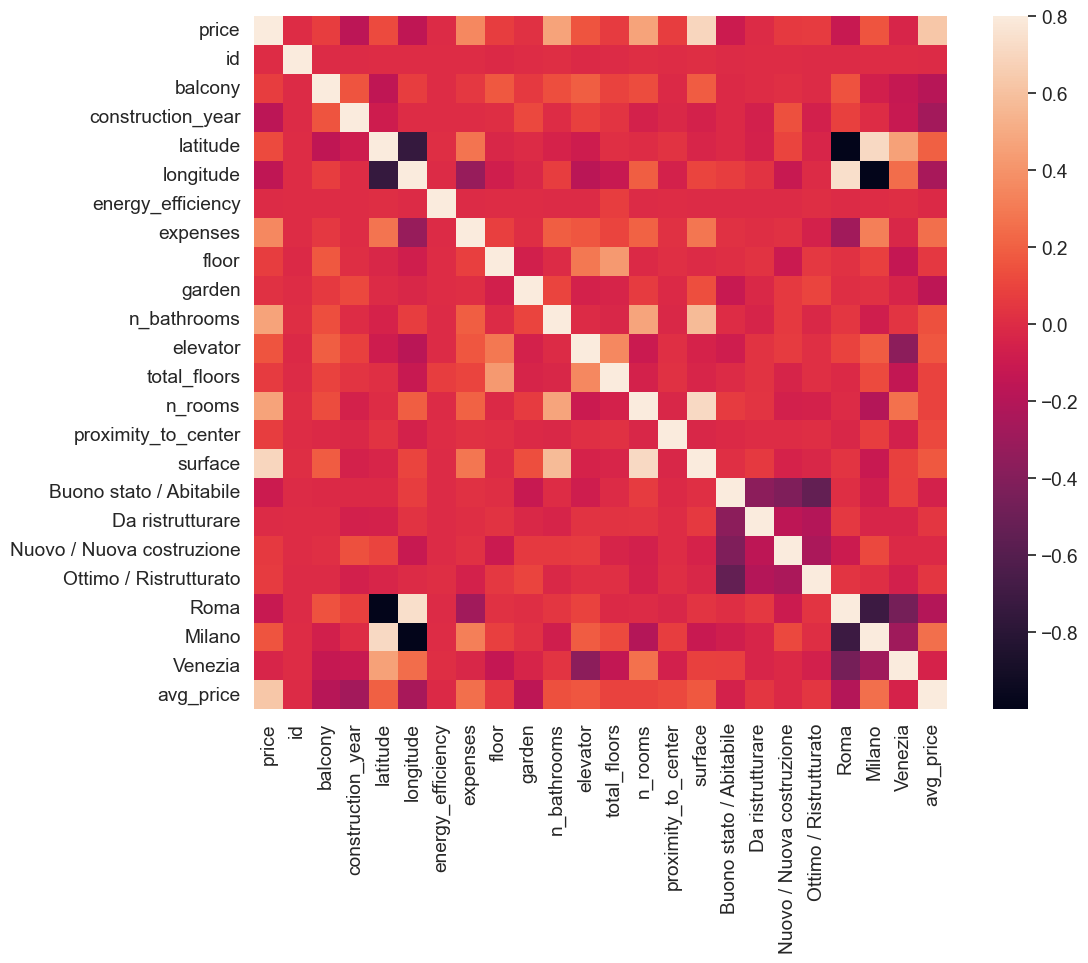

In [2010]:
# Plot the correlation matrix

corrmat = df_corr.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

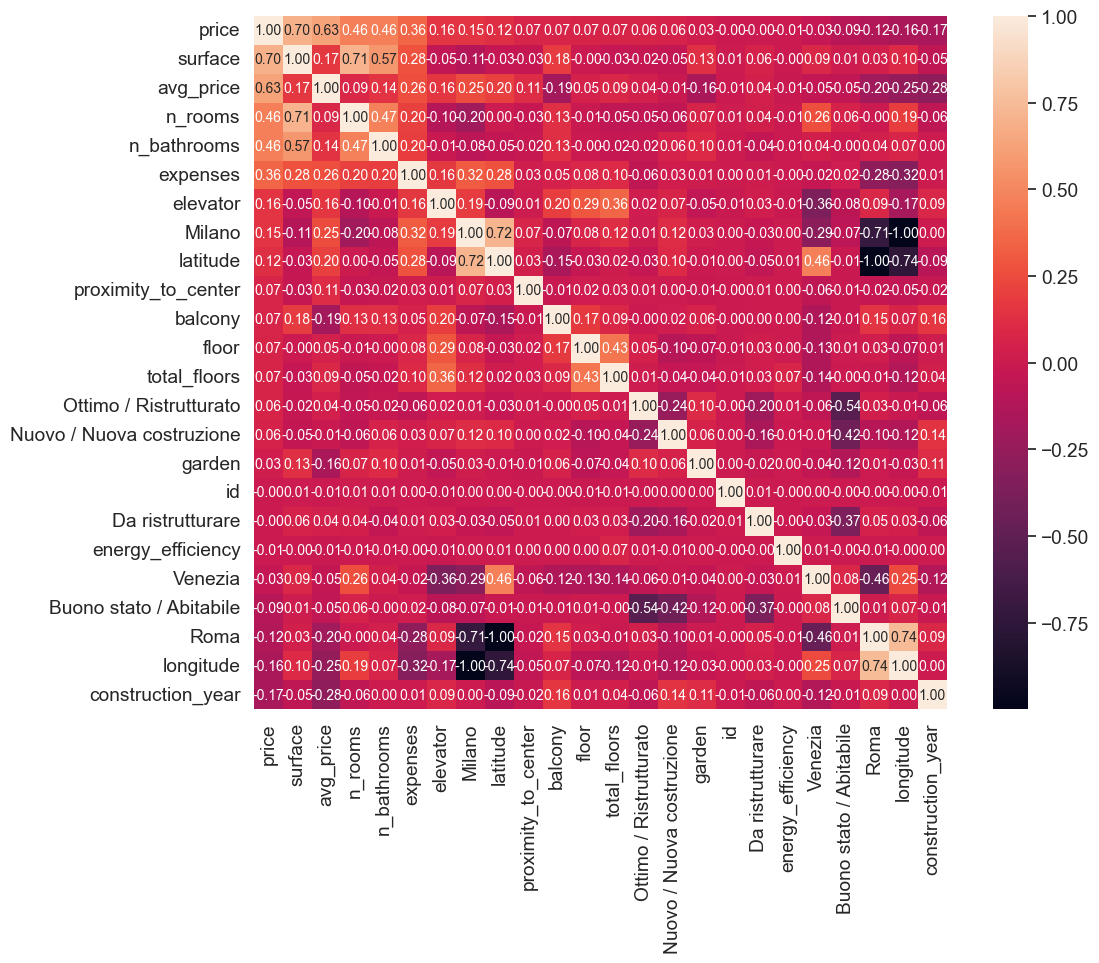

In [2011]:
# Produce correlation matrix heatmap with correlation values

k = 29 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_corr[cols].astype(float).values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

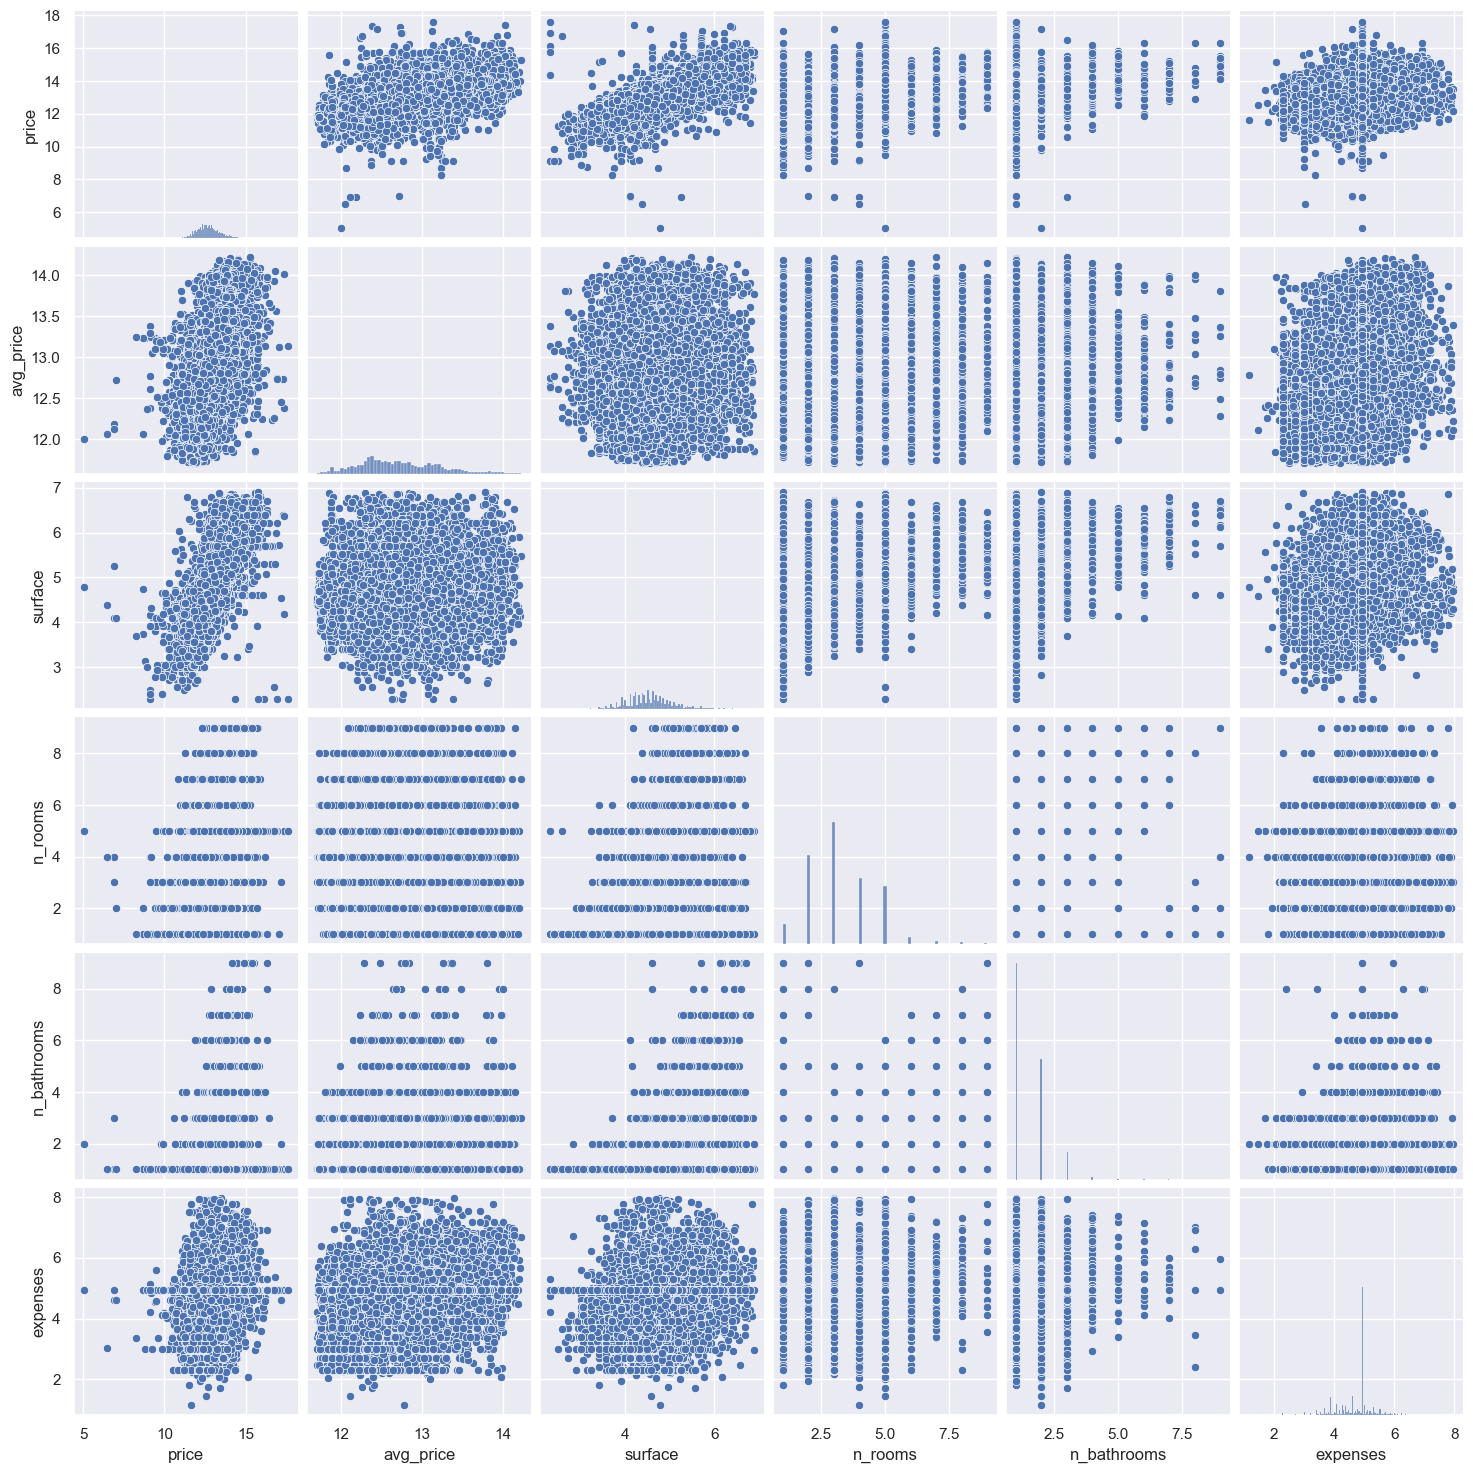

In [2012]:
sns.set()
cols = ['price', 'avg_price', 'surface', 'n_rooms', 'n_bathrooms', 'expenses']
sns.pairplot(df_corr[cols], size = 2.5)
plt.show();

In [2060]:
X_train = df_corr.drop(['price', 'id'], axis = 1)
y_train = df_corr['price']
X_test = df_t.drop(['price', 'id'], axis = 1)
y_test = df_t['price']

## Linear models & KNN

We start predicting prices by assuming a linear relationship between the target variable and its explanatory variables. From our exploratory analysis, we expect that this class of models will not perform very well, but we nevertheless choose it as starting point.

We pick only four explanatory variables that are most correlated with the price of houses, while having little correlation between them. As seen above, surface, n_bathrooms and n_rooms are highly correlated among each other.

In [2061]:
# Choose most correlated features and normalize them

X_train = X_train[['surface', 'avg_price', 'expenses', 'Milano']]
X_train = StandardScaler().fit_transform(X_train)

In [2062]:
# Choose most correlated features and normalize them

X_test = X_test[['surface', 'avg_price', 'expenses', 'Milano']]
X_test = StandardScaler().fit_transform(X_test)

In [2063]:
# Linear regression

# Initialize the model
lr = LinearRegression()

# Fit and predict on training data
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
print(f"Train R^2: {lr.score(X_train, y_train)}.")
print(f"Train MSE: {mean_squared_error(np.exp(y_train), np.exp(train_pred))}.")

# Predict on test data
test_pred = lr.predict(X_test)
print(f"Test R^2: {lr.score(X_test, y_test)}.")
print(f"Test MSE: {mean_squared_error(np.exp(y_test), np.exp(test_pred))}.")

Train R^2: 0.7638323625373896.
Train MSE: 408567297157.62897.
Test R^2: 0.7349853282390051.
Test MSE: 933207060071.7812.


Text(0, 0.5, 'True value')

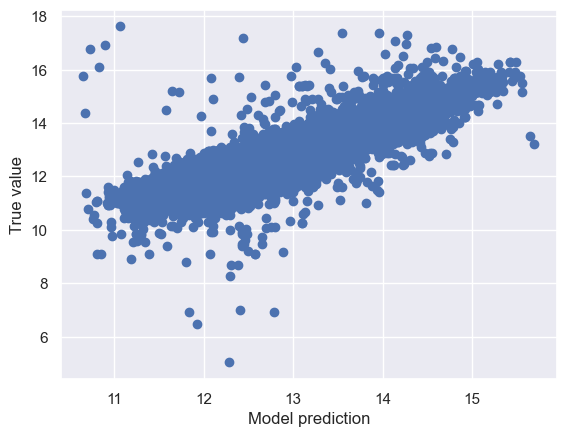

In [2064]:
# plot the preictions

plt.scatter(train_pred, y_train)
plt.xlabel('Model prediction')
plt.ylabel('True value')

We notice that the mean R^2 is reasonably high, but the MSE is high both for the training and for the test data. This indicates that the model might be non-linear, so linear regression is not a suitable model. One issue could also be the outliers, as MSE and linear regression are sensitive to this type of points.

We now move to KNN, Ridge, and Lasso regressions.

k: 2
Train MSE: 263983578077.86703.
Test MSE: 967612520117.6461.
k: 3
Train MSE: 327561648579.38226.
Test MSE: 921327408094.2604.
k: 4
Train MSE: 347864674293.37537.
Test MSE: 922114968199.8334.
k: 5
Train MSE: 359833974526.9647.
Test MSE: 925719568745.6063.
k: 6
Train MSE: 366461804513.59656.
Test MSE: 926116800047.3641.
k: 7
Train MSE: 370021028342.6672.
Test MSE: 925997619215.5436.
k: 8
Train MSE: 371445723009.70496.
Test MSE: 924694150481.657.
k: 9
Train MSE: 376236920535.04333.
Test MSE: 923347223754.6179.
k: 10
Train MSE: 378594864383.7373.
Test MSE: 923163184135.736.
k: 11
Train MSE: 380337139795.6266.
Test MSE: 924810141427.8088.
k: 12
Train MSE: 381856328944.76953.
Test MSE: 926719298564.0243.
k: 13
Train MSE: 384127743461.3402.
Test MSE: 927259829884.032.
k: 14
Train MSE: 385709589193.1305.
Test MSE: 926620945887.0371.
k: 15
Train MSE: 387555013377.1406.
Test MSE: 927477580335.1399.
k: 16
Train MSE: 389508217158.2478.
Test MSE: 927587750016.9749.
k: 17
Train MSE: 390385437335

Text(0, 0.5, 'MSE')

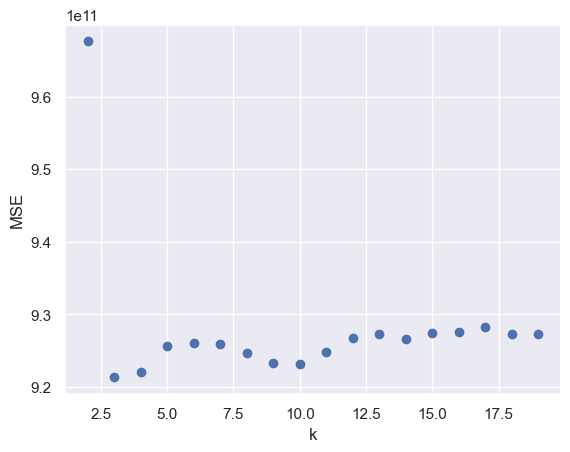

In [2065]:
# Cross-validation for KNN regression

# Note: Even though KNN is a non-parametric model, 
# using the fit function from sklearn ahead of time speeds up prediction,
# as the model stores an internal representation of the data

from sklearn.neighbors import KNeighborsRegressor

ks = []
test_errors = []

# Loop over all k's from 2 to 19 and assess performance
for k in np.arange(2, 20):
    k = int(k)
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, y_train)
    train_pred = knn.predict(X_train)
    print(f"k: {k}")
    print(f"Train MSE: {mean_squared_error(np.exp(y_train), np.exp(train_pred))}.")
    test_pred = knn.predict(X_test)
    print(f"Test MSE: {mean_squared_error(np.exp(y_test), np.exp(test_pred))}.")
    ks.append(k)
    test_errors.append(mean_squared_error(np.exp(y_test), np.exp(test_pred)))
plt.scatter(ks, test_errors)
plt.xlabel('k')
plt.ylabel('MSE')

In [2019]:
# Fit model with the best hyper-parameter

# Intialize the model
knn = KNeighborsRegressor(n_neighbors = 3)

# Predict and fit on training data
knn.fit(X_train, y_train)
train_pred = knn.predict(X_train)
print(f"Train MSE: {mean_squared_error(np.exp(y_train), np.exp(train_pred))}.")

# Predict on test data
test_pred = knn.predict(X_test)
print(f"Test MSE: {mean_squared_error(np.exp(y_test), np.exp(test_pred))}.")

Train MSE: 327561648579.38226.
Test MSE: 921327408094.2604.


In [2024]:
# Ridge regression

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Initialize model
ridge_reg = Ridge(alpha=1000)

# Fit and predict on training data
ridge_reg.fit(X_train, y_train)
train_pred = ridge_reg.predict(X_train)
print(f"Train R^2: {ridge_reg.score(X_train, y_train)}.")
print(f"Train MSE: {mean_squared_error(np.exp(y_train), np.exp(train_pred))}.")

# Fit and predict on test data
test_pred = ridge_reg.predict(X_test)
print(f"Test R^2: {ridge_reg.score(X_test, y_test)}.")
print(f"Test MSE: {mean_squared_error(np.exp(y_test), np.exp(test_pred))}.")

Train R^2: 0.7633969713892393.
Train MSE: 413510508387.22064.
Test R^2: 0.7343249126390956.
Test MSE: 939371741922.7081.


In [2066]:
# Lasso regression

from sklearn.linear_model import Lasso

# Initialize model
lasso_reg = Lasso(alpha=0.05)

# Fit and predict on training data
lasso_reg.fit(X_train, y_train)
y_pred = lasso_reg.predict(X_train)
print(f"MSE train: {mean_squared_error(np.exp(y_train), np.exp(y_pred))}.")

# Fit and predict on test data
test_predictions = lasso_reg.predict(X_test)
print(f"MSE test: {mean_squared_error(np.exp(y_test), np.exp(test_predictions))}.")

MSE train: 433494282524.99384.
MSE test: 960101776347.89.


There do no seem to be major improvements over linear regression. We recognize the need to move to a more complex class of models in the hope of better explainig the variability in the data.

## Enesemble methods

Before proceeding with the ensemble methods, let us go back to our data preparation process. To avoid overfitting to the train data, we simplify our imputaion process and hope that more powerful models should not be as sensitive to outliers as the previous models. Furthermore, these methods are not sensitive to the scale of the data as they partition the input space. Therefore, we shall not apply any transformation (log, or linear) to our data matrix. We also hope that regularization could mitigate the impact of overfiting.

In [2278]:
# Import training data

df_dirty = pd.read_csv('train.csv')

# split data into training and testing sets
X = df_dirty.drop(['price'], axis = 1)
y = df_dirty['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train_dirty = pd.concat([y_train, X_train], axis=1)
df_test_dirty = pd.concat([y_test, X_test], axis=1)

print(df_train_dirty.shape, df_test_dirty.shape)

(37049, 17) (9263, 17)


In [2279]:
# Look at the missing values

total = df_train_dirty.isnull().sum().sort_values(ascending=False)
percent = (df_train_dirty.isnull().sum()/df_train_dirty.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
garden,25226,0.680882
energy_efficiency,15833,0.427353
total_floors,14602,0.394127
elevator,13898,0.375125
expenses,12912,0.348511
balcony,12363,0.333693
construction_year,11175,0.301628
n_bathrooms,1949,0.052606
floor,1625,0.043861
conditions,964,0.026020


In [2280]:
# Main cleaning and preparation function

def prepare_data(df, train_data = True, extra_features = False):
    # drop conditions -> arbitrary labels
    df = df.drop('conditions', axis = 1)
    
    # impute missing values with mean/median according to the nature of the data
    df['garden'] = df['garden'].fillna(False)
    df['elevator'] = df['elevator'].fillna(False)
    df['balcony'] = df['balcony'].fillna(False)
    df['balcony'] = df['balcony'].replace({True: 1, False: 0})
    df['garden'] = df['garden'].replace({True: 1, False: 0})
    df['elevator'] = df['elevator'].replace({True: 1, False: 0})
    df['energy_efficiency'] = df['energy_efficiency'].fillna(df['energy_efficiency'].mean())
    df['total_floors'] = df['total_floors'].fillna(df['total_floors'].median())
    df['expenses'] = df['expenses'].fillna(df['expenses'].mean())
    df['construction_year'] = df['construction_year'].fillna(df['construction_year'].median())
    df['n_bathrooms'] = df['n_bathrooms'].fillna(df['n_bathrooms'].median())
    df['floor'] = df['floor'].fillna(df['floor'].median())
    df['surface'] = df['surface'].fillna(df['surface'].mean())
    df['n_rooms'] = df['n_rooms'].fillna(df['n_rooms'].median())
    df['longitude'] = df['longitude'].fillna(df['longitude'].mean())
    df['latitude'] = df['latitude'].fillna(df['latitude'].mean())
    df['proximity_to_center'] = df['proximity_to_center'].fillna(df['proximity_to_center'].mean())
    
    if extra_features == True:
    
        # compute the average price in the neighbourhood:
        # always use the training data, since test data does not have prices
        # code below is a bit redundant, but works
        if train_data:
            tree = cKDTree(df[['latitude', 'longitude']])
            distances, indices = tree.query(df[['latitude', 'longitude']], k=201)
            avg_prices = []
            for i in range(len(indices)):
                neighbors = indices[i][1:]
                prices = df.iloc[neighbors]['price']
                avg_price = prices.mean()
                avg_prices.append(avg_price)
            df['avg_price'] = avg_prices
        else:
            tree = cKDTree(df_train_clean[['latitude', 'longitude']]) # make sure to take training points as reference
            distances, indices = tree.query(df[['latitude', 'longitude']], k=201)
            avg_prices = []
            for i in range(len(indices)):
                neighbors = indices[i][1:]
                prices = df_train_clean.iloc[neighbors]['price']
                avg_price = prices.mean()
                avg_prices.append(avg_price) 
            df['avg_price'] = avg_prices

    return df

In [2281]:
# Clean train data

df_train_clean = prepare_data(df_train_dirty, train_data = True, extra_features = True)

In [2282]:
# Check that we filled all missing values

total = df_train_clean.isnull().sum().sort_values(ascending=False)
percent = (df_train_clean.isnull().sum()/df_train_clean.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
price,0,0.000000
garden,0,0.000000
surface,0,0.000000
proximity_to_center,0,0.000000
n_rooms,0,0.000000
total_floors,0,0.000000
elevator,0,0.000000
n_bathrooms,0,0.000000
floor,0,0.000000
id,0,0.000000


In [2283]:
# Preview train data

df_train_clean.head()

,price,id,balcony,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,avg_price
1133,320000,61622,0,1960.000000,45.498243,12.248309,6266.493111,190.000000,1.000000,0,2.000000,1,4.000000,4.000000,1.000000,130.000000,252943.240000
18921,450000,13925,0,1986.000000,41.915600,12.387800,6266.493111,0.000000,0.000000,1,2.000000,0,3.000000,5.000000,1.000000,160.000000,465620.750000
36867,580000,54125,0,2022.000000,45.486404,9.161906,6266.493111,50.000000,-1.000000,0,1.000000,0,4.000000,1.000000,1.000000,90.000000,645417.100000
27541,410000,46319,1,1957.000000,41.937400,12.514400,138.800000,110.000000,2.000000,0,1.000000,1,5.000000,3.000000,1.000000,97.000000,578186.875000
14421,259000,56203,1,2011.000000,45.472700,9.116700,22.250000,160.000000,2.000000,1,1.000000,1,8.000000,2.000000,1.000000,73.000000,553890.395000


In [2284]:
# Clean test data

df_test_clean = prepare_data(df_test_dirty, train_data = False, extra_features = True)

In [2285]:
# Preview test data

df_test_clean.head()

,price,id,balcony,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,avg_price
43305,640000,41113,0,1967.000000,45.460700,9.185200,175.000000,250.000000,1.000000,0,1.000000,0,4.000000,2.000000,1.000000,69.000000,1359945.000000
24029,380000,61518,1,1967.000000,45.449145,9.143510,290.463930,265.371533,1.000000,0,2.000000,1,4.000000,3.000000,1.000000,140.000000,425270.500000
5604,200000,30416,0,1967.000000,41.930749,12.520244,186.910000,265.371533,2.000000,0,1.000000,0,4.000000,2.000000,1.000000,75.000000,546265.000000
28187,639000,52738,0,1987.000000,41.845218,12.330052,290.463930,265.371533,2.000000,0,3.000000,0,4.000000,5.000000,1.000000,970.000000,246950.270000
11852,169000,15736,1,2020.000000,41.917105,12.556276,290.463930,50.000000,1.000000,1,1.000000,1,4.000000,1.000000,1.000000,40.000000,247050.195000


In [2286]:
# Separate explanatory and target variables

X_train = df_train_clean.drop(['price', 'id'], axis = 1)
y_train = df_train_clean['price']
X_test = df_test_clean.drop(['price', 'id'], axis = 1)
y_test = df_test_clean['price']
print(X_train.shape, X_test.shape)

(37049, 15) (9263, 15)


In [2057]:
# Start with cross-validation for Random Forest

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Define the model
rf = RandomForestRegressor()

# Define the grid of hyperparameters to search over
param_grid = {'n_estimators': range(50, 100, 10),
              'max_depth': [3, 5, 9],
              'max_features': [5, 7]}

# Perform the grid search with 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean test score
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean test score:", -grid_search.best_score_)

Best hyperparameters: {'max_depth': 9, 'max_features': 5, 'n_estimators': 50}
Best mean test score: 707940489177.9968


In [2290]:
# Train the model with the best hyper-parameters
# Note: even after cross-validation, we have manually changes some parameters 
# to increase both local and Kaggle performance

# Initialize the model
rf = RandomForestRegressor(n_estimators = 40, max_depth = 9, max_features = 7, random_state = 42)

# Train and predict on train data
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
train_err = mean_squared_error(y_train, train_pred)

# Predict on test data
test_pred = rf.predict(X_test)
test_err = mean_squared_error(y_test, test_pred)
print(f"Train MSE: {train_err}.")
print(f"Test MSE: {test_err}.")

Train MSE: 202786106753.80154.
Test MSE: 782487709062.7837.


In [1567]:
# Cross-validation for XGBoost

import xgboost as xgb
from sklearn.model_selection import KFold

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 80, 100, 200],
    'eta': [0.1, 0.2, 0.3],
    'subsample' : [0.5, 0.8, 0.9] 
}

# Create an XGBoost classifier
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform cross-validation to find the best hyperparameters
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train, y_train)

# Print the results
print('Best Score: %f using %s' % (grid_result.best_score_, grid_result.best_params_))


Best Score: -756194510427.535889 using {'eta': 0.1, 'max_depth': 2, 'n_estimators': 80, 'subsample': 0.9}


In [2291]:
# Train XGBoost with optimal parameters
# Note: even after cross-validation, we have manually changes some parameters 
# to increase both local and Kaggle performance

# Initialize model
xgb_model = xgb.XGBRegressor(n_estimators = 80, max_depth = 4, 
                             eta = 0.1,
                             subsample = 0.5, random_state = 42)

# Fit and predict on training data
xgb_model.fit(X_train, y_train)
train_pred = xgb_model.predict(X_train)
train_err = mean_squared_error(y_train, train_pred)

# Fit and predict on test data
test_pred = xgb_model.predict(X_test)
test_err = mean_squared_error(y_test, test_pred)
print(f"Train MSE: {train_err}.")
print(f"Test MSE: {test_err}.")

Train MSE: 307072362358.1544.
Test MSE: 781872679670.7145.


## Prediction for final submission

We now choose the best model and train in on the entire training data set to create the file containing the predictions that we submit to Kaggle.

In [2266]:
# Re-import and clean the training data

train_all_dirty = pd.read_csv(cdir_path + '/data/train.csv')
train_all_clean = prepare_data(train_all_dirty, train_data = True, extra_features = True)
X_train = train_all_clean.drop(['price', 'id'], axis = 1)
y_train = train_all_clean['price']
print(X_train.shape)

(46312, 15)


In [2267]:
# Preview the training data

df_test_dirty = pd.read_csv(cdir_path + '/data/test_updated.csv')
df_test_dirty.head()

,id,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,18825,True,Nuovo / Nuova costruzione,2010.000000,41.917500,12.655400,175.000000,1.000000,3.000000,True,1.000000,1.000000,5.000000,2.000000,1.000000,72.000000
1,30956,NaN,Buono stato / Abitabile,1900.000000,45.446100,12.326700,175.000000,0.000000,0.000000,True,1.000000,NaN,3.000000,2.000000,1.000000,60.000000
2,47193,NaN,Buono stato / Abitabile,NaN,45.456925,9.194406,NaN,NaN,-1.000000,NaN,3.000000,0.000000,NaN,3.000000,1.000000,140.000000
3,27799,True,Buono stato / Abitabile,1962.000000,45.483800,12.259000,198.870000,NaN,6.000000,NaN,NaN,NaN,6.000000,3.000000,1.000000,98.000000
4,22259,True,Buono stato / Abitabile,2006.000000,41.899400,12.659500,175.000000,65.000000,4.000000,NaN,2.000000,1.000000,4.000000,3.000000,1.000000,83.000000


In [2268]:
# Clean and preview the test data

df_test_clean = prepare_data(df_test_dirty, train_data = False, extra_features = True)
df_test_clean.head()

,id,balcony,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,avg_price
0,18825,1,2010.000000,41.917500,12.655400,175.000000,1.000000,3.000000,1,1.000000,1,5.000000,2.000000,1.000000,72.000000,155407.370000
1,30956,0,1900.000000,45.446100,12.326700,175.000000,0.000000,0.000000,1,1.000000,0,3.000000,2.000000,1.000000,60.000000,567630.000000
2,47193,0,1967.000000,45.456925,9.194406,512.507356,232.630803,-1.000000,0,3.000000,0,4.000000,3.000000,1.000000,140.000000,967378.000000
3,27799,1,1962.000000,45.483800,12.259000,198.870000,232.630803,6.000000,0,1.000000,0,6.000000,3.000000,1.000000,98.000000,210124.700000
4,22259,1,2006.000000,41.899400,12.659500,175.000000,65.000000,4.000000,0,2.000000,1,4.000000,3.000000,1.000000,83.000000,153302.120000


In [2269]:
# Make sure to use the same columns as in the trainig data

X_test = df_test_clean[X_train.columns]

In [2276]:
# Use the best model to make final predictions

# Initialize model
xgb_model = xgb.XGBRegressor(n_estimators = 80, max_depth = 4, 
                             eta = 0.1,
                             subsample = 0.5, random_state = 42)

# Fit and predict on training data
xgb_model.fit(X_train, y_train)
train_pred = xgb_model.predict(X_train)
train_err = mean_squared_error(y_train, train_pred)

# Fit on test data
test_pred = xgb_model.predict(X_test)
print(f"Train MSE: {train_err}.")

Train MSE: 390732021548.0491.


In [2277]:
# Output to csv file and check that the format is correct

predictions = test_pred
ids = df_test_clean['id'].to_numpy()
output = pd.DataFrame({'id': ids, 'price': predictions})
output.to_csv(cdir_path + '/data/output.csv', index = False)
t = pd.read_csv(cdir_path + '/data/output.csv')
t.head()

,id,price
0,18825,159086.330000
1,30956,275787.560000
2,47193,851639.100000
3,27799,235547.560000
4,22259,205852.830000


## Conclusion

We went through a long and meticulous process to clean, prepare, train, and predict using the data that was provided to us. From exploratory data analysis, to the actual modelling, we tried many different approaches. We noticed strange patterns in the data (e.g., construction year is negatively correlated with price). We fitted many models, from linear regression, to XGBoost, and we tried many different sets of parameters. In the end, we believe that our analysis was based on strong theoretical foundations and good empirical observations, to obtain a final model that predicts house prices reasonably well.

**Credits**: Lecture notes & TA notebooks, Stack Overflow, Towards Data Science, sklearn & XGBoost documentation.